# Redes Neurais - Previsão de Série Temporal: Valor do Bitcoin

| Hiperparâmetro específicos da LSTM | O que controla?                   | Valores típicos  |
| -------------- | --------------------------------- | ---------------- |
| `hidden_dim`   | Tamanho do vetor de estado oculto | 32, 64, 128, 256 |
| `layer_dim`    | Nº de camadas LSTM empilhadas     | 1, 2, às vezes 3 |
| `seq_length`   | Tamanho da janela de tempo usada para prever a próximo valor |  |

### Grupo 19:
- Ana Sofia Lima (asosl)
- Arthur Marsaro (aam4)
- João Vitor Mergulhão (jvlm2)
- Pedro Monte (pvom)
- Victor Matheus (vmap)

## Importa Bibliotecas e Prepara Device

In [4]:
import pandas as pd
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import TensorDataset, DataLoader

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

Usando dispositivo: cuda


## Carregamento e Visualização dos Dados

In [6]:
df = pd.read_csv('data_bitcoin.csv')

In [7]:
df.head()

,date,open,high,low,close,number_of_trades
0,2017-08-17,4261.48,4485.39,4200.74,4285.08,3427
1,2017-08-18,4285.08,4371.52,3938.77,4108.37,5233
2,2017-08-19,4108.37,4184.69,3850.00,4139.98,2153
3,2017-08-20,4139.98,4211.08,4032.62,4086.29,2321
4,2017-08-21,4069.13,4119.62,3911.79,4016.00,3972


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2176 entries, 0 to 2175
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   date              2176 non-null   object 
 1   open              2176 non-null   float64
 2   high              2176 non-null   float64
 3   low               2176 non-null   float64
 4   close             2176 non-null   float64
 5   number_of_trades  2176 non-null   int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 102.1+ KB


In [9]:
df.describe()

,open,high,low,close,number_of_trades
count,2176.000000,2176.000000,2176.000000,2176.000000,2.176000e+03
mean,20074.277578,20613.574283,19468.753051,20085.572486,1.462627e+06
std,16058.230026,16490.568746,15560.344106,16055.913598,2.057254e+06
min,3188.010000,3276.500000,2817.000000,3189.020000,2.153000e+03
25%,7627.735000,7829.747500,7424.250000,7628.355000,2.803172e+05
50%,11705.580000,11933.360000,11334.110000,11728.035000,7.407820e+05
75%,29866.525000,30423.460000,29224.382500,29866.532500,1.595982e+06
max,67525.820000,69000.000000,66222.400000,67525.830000,1.522359e+07


In [10]:
df_close = df['close']

In [11]:
df_close.head()

,close
0,4285.08
1,4108.37
2,4139.98
3,4086.29
4,4016.00


/tmp/ipython-input-12-746020422.py:31: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='best')


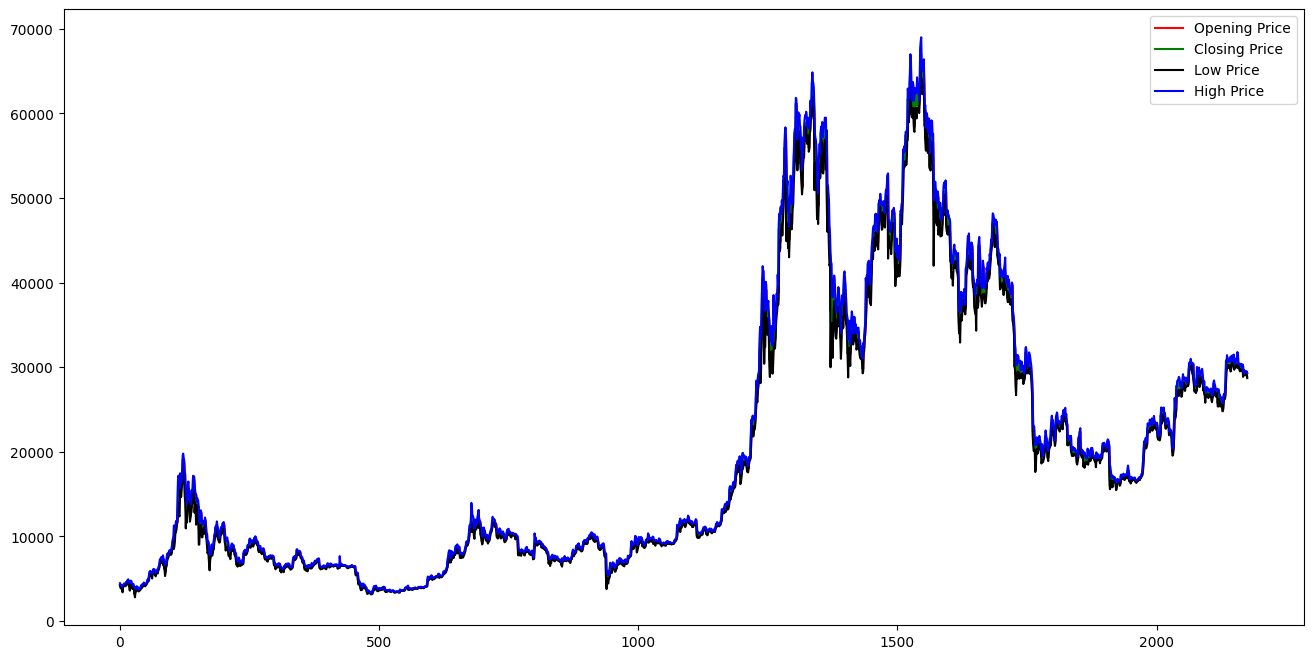

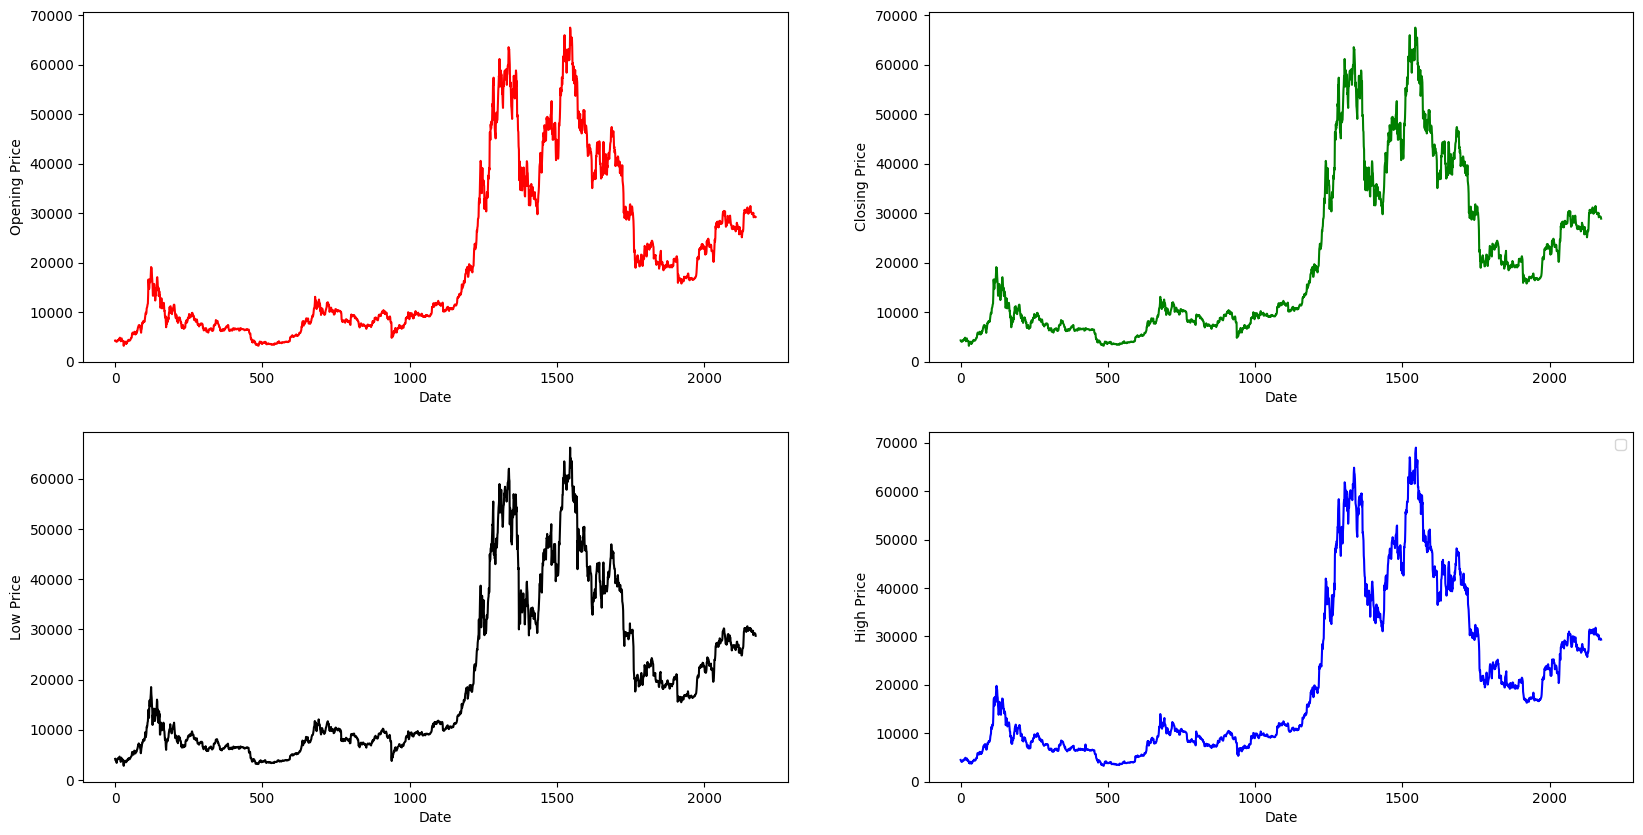

In [12]:
plt.figure(figsize=(16,8), dpi= 100, facecolor='w', edgecolor='k')

plt.plot(df['open'], color='red', label = 'Opening Price')
plt.plot(df['close'], color='green', label = 'Closing Price')
plt.plot(df['low'], color='black', label = 'Low Price')
plt.plot(df['high'], color='blue', label = 'High Price')
plt.legend(loc='best')

plt.subplots(2, 2, figsize = (20, 10))

ax1 = plt.subplot(2, 2, 1)
plt.plot(df['open'], color='red')
plt.xlabel('Date')
plt.ylabel('Opening Price')

ax2 = plt.subplot(2, 2, 2)
plt.plot(df['close'], color='green')
plt.xlabel('Date')
plt.ylabel('Closing Price')

ax3 = plt.subplot(2, 2, 3)
plt.plot(df['low'], color='black')
plt.xlabel('Date')
plt.ylabel('Low Price')

ax4 = plt.subplot(2, 2, 4)
plt.plot(df['high'], color='blue')
plt.xlabel('Date')
plt.ylabel('High Price')

plt.legend(loc='best')

## Definição do Modelo e Treinamento

In [13]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, dropout=0.0):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x, h0=None, c0=None):
        if h0 is None or c0 is None:
            h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).to(x.device)
            c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).to(x.device)

        out, (hn, cn) = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out, hn, cn

In [14]:
def train_lstm(model, criterion, optimizer,
                          trainX, trainY, valX, valY,
                          num_epochs=100, patience=10, min_delta=1e-4):
    best_val_loss = float('inf')
    epochs_no_improve = 0
    best_model_state = None

    for epoch in range(1, num_epochs+1):
        # ---- Treino ----
        model.train()
        optimizer.zero_grad()
        outputs, h0, c0 = model(trainX)
        loss = criterion(outputs, trainY)
        loss.backward()
        optimizer.step()

        # ---- Validação ----
        model.eval()
        with torch.no_grad():
            val_outputs, _, _ = model(valX)
            val_loss = criterion(val_outputs, valY)

        # ---- Checa melhoria ----
        if val_loss < best_val_loss - min_delta:
            best_val_loss = val_loss
            epochs_no_improve = 0
            best_model_state = model.state_dict()  # guarda melhor modelo
        else:
            epochs_no_improve += 1

        # ---- Log ----
        if epoch % 10 == 0 or epoch == 1:
            print(f'Época {epoch}/{num_epochs} — '
                  f'Train Loss: {loss.item():.4f} — '
                  f'Val Loss: {val_loss.item():.4f} — '
                  f'Streak: {epochs_no_improve}/{patience}')

        # ---- Early Stopping ----
        if epochs_no_improve >= patience:
            print(f'--> Early stopping na época {epoch}. '
                  f'Melhor Val Loss: {best_val_loss:.4f}')
            break

    # Restaura pesos do melhor modelo
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
    return model, best_val_loss


In [15]:
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:(i + seq_length)]
        y = data[i + seq_length]
        xs.append(x)
        ys.append(y)
    return torch.stack(xs), torch.stack(ys)

## Função para Previsão Multi-Step

Cria um loop em que cada iteração usa a lstm para fazer a previsão um passo a frente. Na primeira iteração faz a previsão baseado em seq_length valores reais, na segunda usa o seq_length - 1 valores reais e o último valor previsto e assim por diante:
* Faz uma previsão 1 passo à frente
* Cria uma nova janela em que remove o primeiro valor a adiciona a nova previsão

In [16]:
def forecast_n_steps(model, last_window, n_steps, input_dim):
    """
    model: modelo LSTM treinado
    last_window: tensor (1, seq_length, input_dim) -> última janela real
    n_steps: quantos passos você quer prever
    input_dim: número de features (1 se for univariado)
    """
    model.eval()
    preds = []
    window = last_window.clone()

    with torch.no_grad():
        h0, c0 = None, None

        for _ in range(n_steps):
            # Faz uma previsão 1 passo à frente
            y_pred, h0, c0 = model(window, h0, c0)

            # Guarda a previsão
            preds.append(y_pred.item())

            # Cria novo input com a previsão
            new_input = y_pred.view(1, 1, input_dim)

            # Remove o primeiro valor da janela e adiciona o novo
            window = torch.cat([window[:, 1:, :], new_input], dim=1)

            # Para estabilidade: detach dos hidden states
            h0 = h0.detach()
            c0 = c0.detach()

    return preds


## Funções Auxiliares

In [17]:
import numpy as np

def inverse_transform_single_column(y_pred, scaler, num_feat, col_idx=0):
    """
    Desfaz a normalização de uma previsão de 1 coluna,
    usando o scaler que espera todas as features.

    Parâmetros:
    ----------
    y_pred : torch.Tensor ou np.ndarray
        Previsões normalizadas (shape: [N, 1] ou [N])
    scaler : sklearn MinMaxScaler
        O scaler já ajustado nos dados originais.
    num_feat : int
        Número total de features que o scaler espera.
    col_idx : int
        Índice da coluna onde a previsão estava (default: 0)

    Retorna:
    -------
    y_pred_denorm : np.ndarray
        Previsões desnormalizadas (shape: [N, 1])
    """

    # Se for tensor, converte pra numpy
    if hasattr(y_pred, 'cpu'):
        y_pred_np = y_pred.detach().cpu().numpy()
    else:
        y_pred_np = np.asarray(y_pred)

    # Garante forma correta
    y_pred_np = y_pred_np.squeeze()

    if y_pred_np.ndim == 0:
        y_pred_np = np.expand_dims(y_pred_np, 0)

    N = y_pred_np.shape[0]

    # Cria vetor fake com todas features
    y_pred_full = np.zeros((N, num_feat))
    y_pred_full[:, col_idx] = y_pred_np

    # Faz inverse transform
    y_pred_denorm_full = scaler.inverse_transform(y_pred_full)

    # Pega só a coluna de interesse
    y_pred_denorm = y_pred_denorm_full[:, col_idx].reshape(-1, 1)

    return y_pred_denorm

In [18]:
import numpy as np
import matplotlib.pyplot as plt

def plot_lstm_forecast(y_pred, X_raw, X_test, seq_length, label='Value'):
    """
    Plota previsões do modelo LSTM junto com os dados originais e a série combinada.

    Parâmetros:
    -----------
    y_pred_test : torch.Tensor
        Previsões do modelo em tensor.
    X_raw : numpy.ndarray
        Série original (não escalada).
    X_test : torch.Tensor
        Conjunto de teste em formato sequencial.
    seq_length : int
        Comprimento da janela de entrada usada na LSTM.
    label : str
        Nome do eixo Y (default: 'Value').
    """

    # Cria vetor de tempo para o trecho previsto
    original = X_raw[-len(y_pred):]
    time_pred = np.arange(len(X_raw) - len(y_pred), len(X_raw))

    # Reconstrói a série combinada
    look_back = seq_length
    train_end_idx = len(X_raw) - len(X_test) - look_back + 1

    real_part = X_raw[:train_end_idx].squeeze()
    forecast_part = y_pred.squeeze()

    combined = np.concatenate((real_part, forecast_part))
    time_combined = np.arange(len(combined))

    # Cria figura com subplots lado a lado
    fig, axs = plt.subplots(1, 2, figsize=(16, 6))

    # Subplot 1: Previsão local vs real
    axs[0].plot(time_pred, original, label='Original Data')
    axs[0].plot(time_pred, y_pred.squeeze(), label='Predicted Data', linestyle='--')
    axs[0].set_title('LSTM Predictions vs. Original Data')
    axs[0].set_xlabel('Time Step')
    axs[0].set_ylabel(label)
    axs[0].legend()

    # Subplot 2: Série combinada completa
    axs[1].plot(time_combined, combined, label='Combined Real + Predicted', linestyle='-')
    axs[1].axvline(x=len(real_part)-1, color='r', linestyle='--', label='Start of Prediction')
    axs[1].set_title('Full Series with Forecast Appended')
    axs[1].set_xlabel('Time Step')
    axs[1].set_ylabel(label)
    axs[1].legend()

    plt.tight_layout()
    plt.show()

    return combined


## Separação dos dados

Separação dos dados:
* 80% dos dados foram separados para o treinamento e 20% ficam reservados para o teste.

* X_all_train e X_all_test têm 5 features e são utilizados como conjuntos de treinamento e teste na abordagem 2.

* X_close_train e X_close_test apresentam apenas a feature `close` e são utilizados na abordagem 1.

Obs. é importante utilizar fit_transform apenas no conjunto de treinamento para evitar data leakege, caso o scaler seja treinado no conjunto inteiro. estatísticas de dados futuros iriam influenciar a normalização dos outros dados.

In [19]:
# 1) Remove coluna date e extrai array numpy
df_raw = df.drop('date', axis=1)
X_raw  = df_raw.values
N      = len(X_raw)

# 2) Calcula tamanhos: 70% treino, 10% validação, 20% teste
train_size = int(N * 0.7)
val_size   = int(N * 0.1)
# test_size = N - train_size - val_size  # implícito

# 3) Faz o split temporal
X_train_raw = X_raw[:train_size]
X_val_raw   = X_raw[train_size:train_size + val_size]
X_test_raw  = X_raw[train_size + val_size:]

# 4) Normaliza **apenas** com scaler ajustado no treino
scaler      = MinMaxScaler(feature_range=(0, 1))
X_all_train = scaler.fit_transform(X_train_raw)
X_all_val   = scaler.transform(X_val_raw)
X_all_test  = scaler.transform(X_test_raw)

# 5) Converte para tensor e leva a GPU (se houver)
X_all_train = torch.tensor(X_all_train, dtype=torch.float32).to(device)
X_all_val   = torch.tensor(X_all_val,   dtype=torch.float32).to(device)
X_all_test  = torch.tensor(X_all_test,  dtype=torch.float32).to(device)

# 6) Extrai só a série 'close' (penúltima coluna) para cada split
X_close_train = X_all_train[:, -2].unsqueeze(1)  # shape (N_train, 1)
X_close_val   = X_all_val[:,   -2].unsqueeze(1)  # shape (N_val,   1)
X_close_test  = X_all_test[:,  -2].unsqueeze(1)  # shape (N_test,  1)

# 7) Verificação de shapes
print("train:", X_all_train.shape, "close:", X_close_train.shape)
print(" val:  ", X_all_val.shape,   "close:", X_close_val.shape)
print("test:  ", X_all_test.shape,  "close:", X_close_test.shape)

train: torch.Size([1523, 5]) close: torch.Size([1523, 1])
 val:   torch.Size([217, 5]) close: torch.Size([217, 1])
test:   torch.Size([436, 5]) close: torch.Size([436, 1])


## Abordagem 1: Apenas os valores de fechamento

In [20]:
# Hiperparâmetros
seq_length = 10
num_epochs = 1000
hidden_dim = 100
layer_dim = 1
learning_rate = 0.01
patience = 20

In [21]:
# cria sequências
X_train, Y_train = create_sequences(X_close_train, seq_length)
X_val, Y_val = create_sequences(X_close_val, seq_length)
X_test, Y_test = create_sequences(X_close_test, seq_length)

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

torch.Size([1513, 10, 1])
torch.Size([207, 10, 1])
torch.Size([426, 10, 1])


In [22]:
model = LSTMModel(input_dim=1, hidden_dim=hidden_dim, layer_dim=layer_dim, output_dim=1)
model.to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [23]:
train_lstm(model, criterion, optimizer, X_train, Y_train, X_val, Y_val, num_epochs, patience=patience)

Época 1/1000 — Train Loss: 0.1810 — Val Loss: 0.4338 — Streak: 0/20
Época 10/1000 — Train Loss: 0.0420 — Val Loss: 0.1404 — Streak: 7/20
Época 20/1000 — Train Loss: 0.0044 — Val Loss: 0.0209 — Streak: 6/20
Época 30/1000 — Train Loss: 0.0024 — Val Loss: 0.0017 — Streak: 1/20
Época 40/1000 — Train Loss: 0.0011 — Val Loss: 0.0042 — Streak: 11/20
--> Early stopping na época 49. Melhor Val Loss: 0.0011


(LSTMModel(
   (lstm): LSTM(1, 100, batch_first=True)
   (fc): Linear(in_features=100, out_features=1, bias=True)
 ),
 tensor(0.0011, device='cuda:0'))

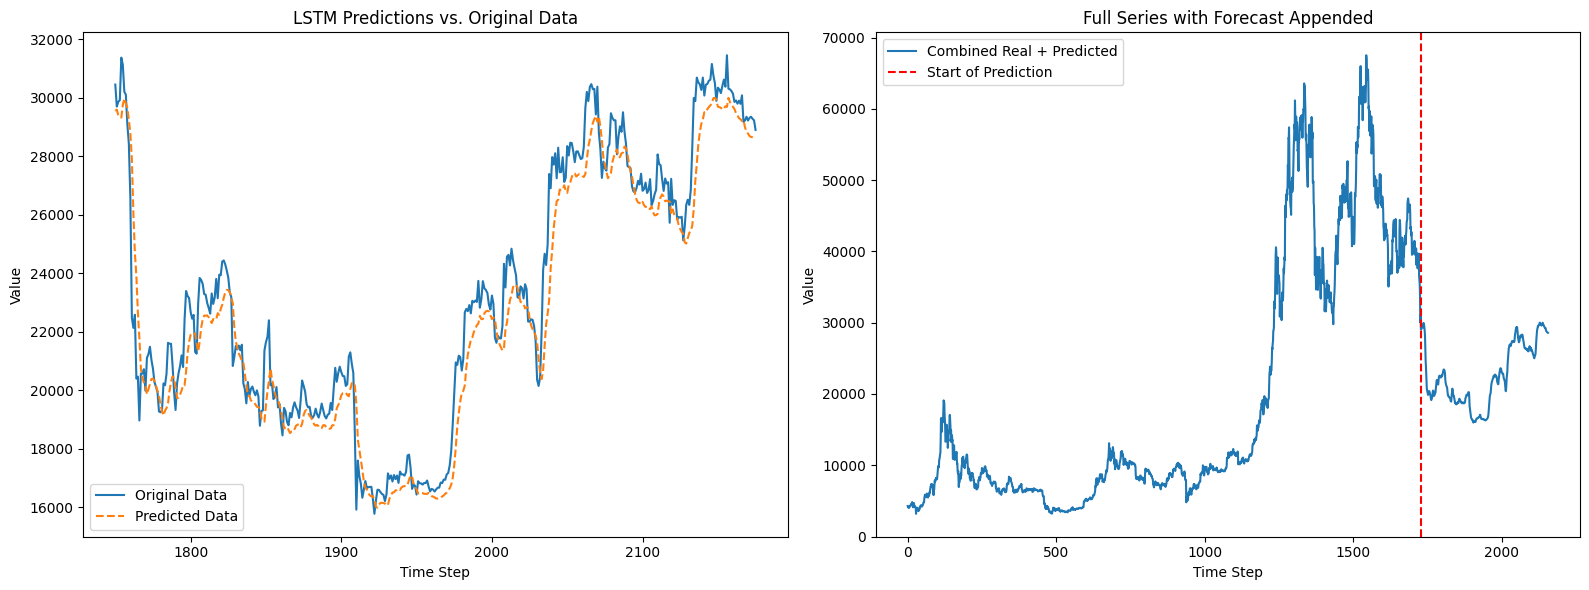

array([ 4285.08      ,  4108.37      ,  4139.98      , ...,
       28650.30507378, 28617.71299861, 28577.124977  ])

In [24]:
model.eval()
with torch.no_grad():
    y_pred_test, _, _ = model(X_test)

y_pred_denorm = inverse_transform_single_column(y_pred_test, scaler, num_feat=5)

plot_lstm_forecast(y_pred_denorm, df_close.values, X_close_test, seq_length)

### Previsão Multi-Step

In [25]:
last_window = X_train[-1].unsqueeze(0)  # (1, seq_length, input_dim)

# roda a previsão multi-step
future_preds = forecast_n_steps(
    model=model,
    last_window=last_window,
    n_steps=30,
    input_dim=1
)

y_pred_denorm = inverse_transform_single_column(future_preds, scaler, num_feat=5)

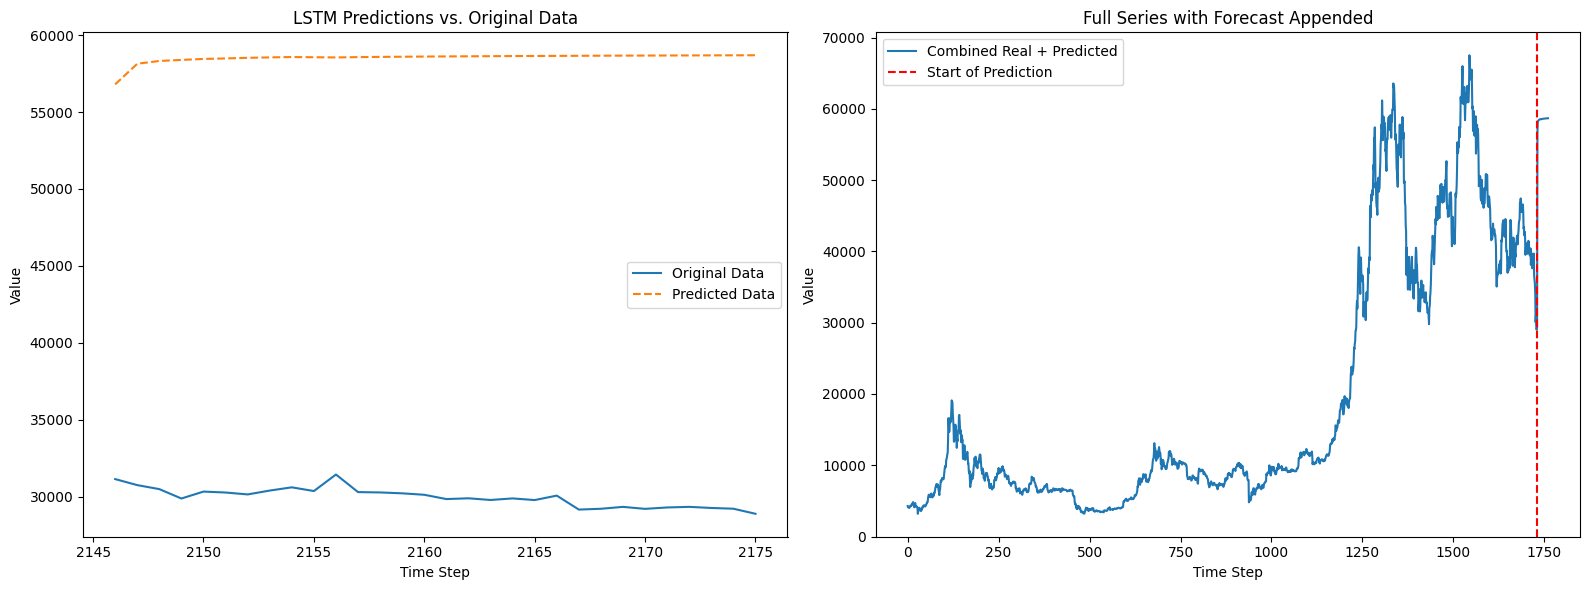

array([ 4285.08      ,  4108.37      ,  4139.98      , ...,
       58680.14102585, 58683.74757023, 58687.12375648])

In [26]:
plot_lstm_forecast(y_pred_denorm, df_close.values, X_close_test, seq_length)

## Abordagem 2: Usando Todas as Features

In [27]:
# Hiperparâmetros
seq_length = 10
num_epochs = 1000
hidden_dim = 100
layer_dim = 1
learning_rate = 0.01
num_feat = 5
patience = 20

In [28]:
# cria sequências
X_train, _ = create_sequences(X_all_train, seq_length)
X_val, _ = create_sequences(X_all_val, seq_length)
X_test, _ = create_sequences(X_all_test, seq_length)

_, Y_train = create_sequences(X_close_train, seq_length)
_, Y_val = create_sequences(X_close_val, seq_length)
_, Y_test = create_sequences(X_close_test, seq_length)

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)
print(Y_train.shape)

torch.Size([1513, 10, 5])
torch.Size([207, 10, 5])
torch.Size([426, 10, 5])
torch.Size([1513, 1])


In [29]:
model = LSTMModel(input_dim=num_feat, hidden_dim=hidden_dim, layer_dim=layer_dim, output_dim=1)
model.to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [30]:
train_lstm(model, criterion, optimizer, X_train, Y_train, X_val, Y_val, num_epochs, patience=patience)

Época 1/1000 — Train Loss: 0.0975 — Val Loss: 0.1154 — Streak: 0/20
Época 10/1000 — Train Loss: 0.0037 — Val Loss: 0.0026 — Streak: 0/20
Época 20/1000 — Train Loss: 0.0026 — Val Loss: 0.0074 — Streak: 3/20
Época 30/1000 — Train Loss: 0.0009 — Val Loss: 0.0019 — Streak: 8/20
Época 40/1000 — Train Loss: 0.0007 — Val Loss: 0.0012 — Streak: 0/20
Época 50/1000 — Train Loss: 0.0006 — Val Loss: 0.0015 — Streak: 10/20
Época 60/1000 — Train Loss: 0.0005 — Val Loss: 0.0011 — Streak: 1/20
Época 70/1000 — Train Loss: 0.0004 — Val Loss: 0.0011 — Streak: 11/20
--> Early stopping na época 79. Melhor Val Loss: 0.0011


(LSTMModel(
   (lstm): LSTM(5, 100, batch_first=True)
   (fc): Linear(in_features=100, out_features=1, bias=True)
 ),
 tensor(0.0011, device='cuda:0'))

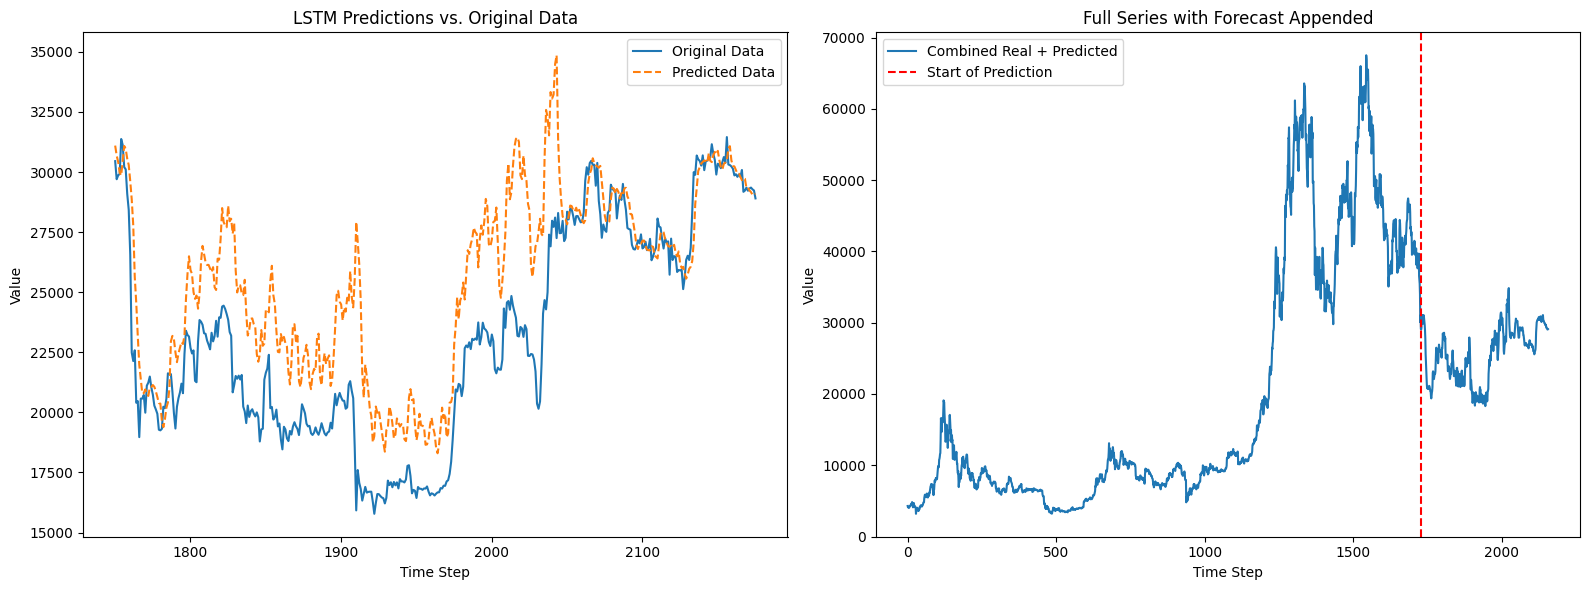

array([ 4285.08      ,  4108.37      ,  4139.98      , ...,
       29054.63937087, 29049.11977426, 29097.48598189])

In [31]:
model.eval()
with torch.no_grad():
    y_pred_test, _, _ = model(X_test)

y_pred_denorm = inverse_transform_single_column(y_pred_test, scaler, num_feat=5)

plot_lstm_forecast(y_pred_denorm, df_close.values, X_close_test, seq_length)

# Experimentos

Variamos:
* Janela
* Número de Dimensões
* Tamanho da Dimensão
* Otimizador
* Clip Margin
* Uso de Optuna

## Experimento - Mudança na Janela

Mudando a Janela para 50

In [32]:
# Hiperparâmetros
seq_length = 50
num_epochs = 1000
hidden_dim = 100
layer_dim = 1
learning_rate = 0.01
patience = 20

In [33]:
# cria sequências
X_train, Y_train = create_sequences(X_close_train, seq_length)
X_val, Y_val = create_sequences(X_close_val, seq_length)
X_test, Y_test = create_sequences(X_close_test, seq_length)

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

torch.Size([1473, 50, 1])
torch.Size([167, 50, 1])
torch.Size([386, 50, 1])


In [34]:
model = LSTMModel(input_dim=1, hidden_dim=hidden_dim, layer_dim=layer_dim, output_dim=1)
model.to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [35]:
train_lstm(model, criterion, optimizer, X_train, Y_train, X_val, Y_val, num_epochs, patience=patience)

Época 1/1000 — Train Loss: 0.1023 — Val Loss: 0.1372 — Streak: 0/20
Época 10/1000 — Train Loss: 0.0467 — Val Loss: 0.0331 — Streak: 2/20
Época 20/1000 — Train Loss: 0.0174 — Val Loss: 0.0125 — Streak: 12/20
Época 30/1000 — Train Loss: 0.0033 — Val Loss: 0.0026 — Streak: 7/20
Época 40/1000 — Train Loss: 0.0011 — Val Loss: 0.0015 — Streak: 8/20
Época 50/1000 — Train Loss: 0.0007 — Val Loss: 0.0009 — Streak: 18/20
--> Early stopping na época 52. Melhor Val Loss: 0.0008


(LSTMModel(
   (lstm): LSTM(1, 100, batch_first=True)
   (fc): Linear(in_features=100, out_features=1, bias=True)
 ),
 tensor(0.0008, device='cuda:0'))

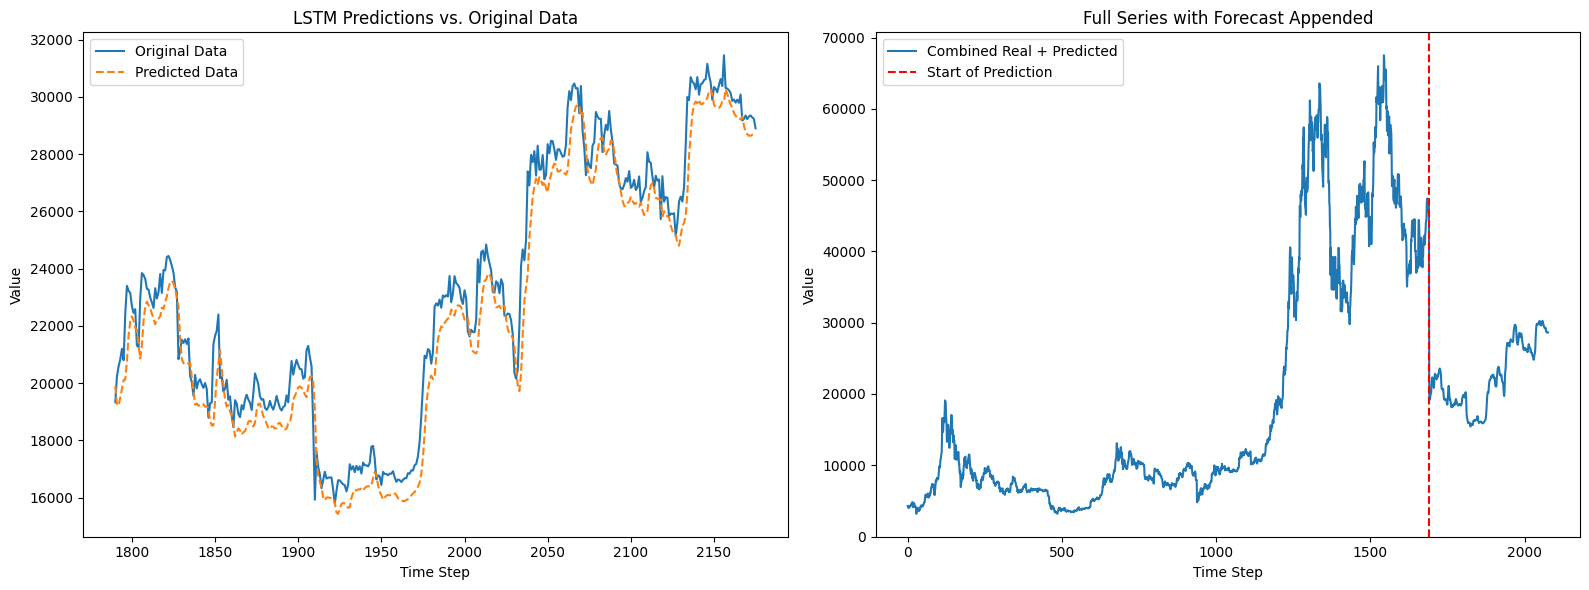

array([ 4285.08      ,  4108.37      ,  4139.98      , ...,
       28672.86217318, 28661.90756459, 28626.80494581])

In [36]:
model.eval()
with torch.no_grad():
    y_pred_test, _, _ = model(X_test)

y_pred_denorm = inverse_transform_single_column(y_pred_test, scaler, num_feat=5)

plot_lstm_forecast(y_pred_denorm, df_close.values, X_close_test, seq_length)

## Experimento - Mudança na Janela

Mudança da Janela para 5

In [37]:
# Hiperparâmetros
seq_length = 5
num_epochs = 1000
hidden_dim = 100
layer_dim = 1
learning_rate = 0.01
patience = 20

In [38]:
# cria sequências
X_train, Y_train = create_sequences(X_close_train, seq_length)
X_val, Y_val = create_sequences(X_close_val, seq_length)
X_test, Y_test = create_sequences(X_close_test, seq_length)

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

torch.Size([1518, 5, 1])
torch.Size([212, 5, 1])
torch.Size([431, 5, 1])


In [39]:
model = LSTMModel(input_dim=1, hidden_dim=hidden_dim, layer_dim=layer_dim, output_dim=1)
model.to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [40]:
train_lstm(model, criterion, optimizer, X_train, Y_train, X_val, Y_val, num_epochs, patience=patience)

Época 1/1000 — Train Loss: 0.0831 — Val Loss: 0.1810 — Streak: 0/20
Época 10/1000 — Train Loss: 0.0082 — Val Loss: 0.0165 — Streak: 1/20
Época 20/1000 — Train Loss: 0.0016 — Val Loss: 0.0035 — Streak: 5/20
Época 30/1000 — Train Loss: 0.0014 — Val Loss: 0.0024 — Streak: 2/20
Época 40/1000 — Train Loss: 0.0007 — Val Loss: 0.0015 — Streak: 12/20
--> Early stopping na época 48. Melhor Val Loss: 0.0013


(LSTMModel(
   (lstm): LSTM(1, 100, batch_first=True)
   (fc): Linear(in_features=100, out_features=1, bias=True)
 ),
 tensor(0.0013, device='cuda:0'))

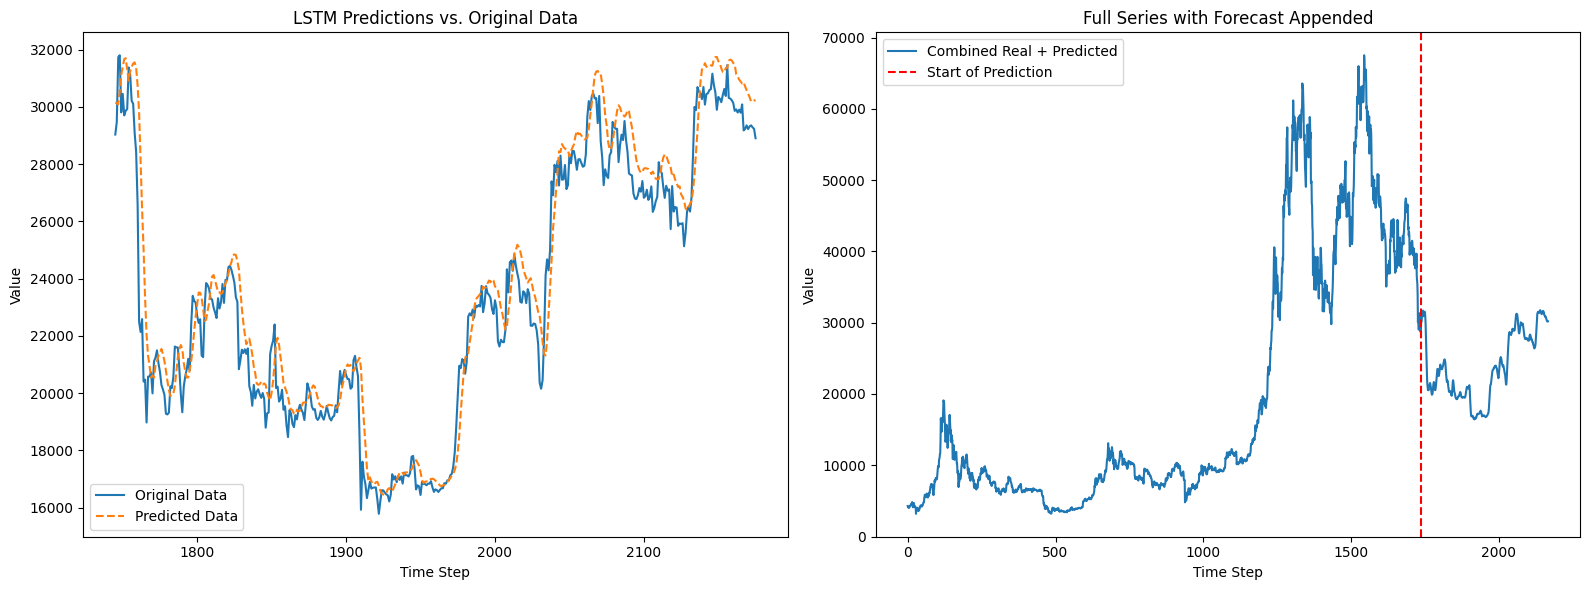

array([ 4285.08      ,  4108.37      ,  4139.98      , ...,
       30219.32464568, 30230.53300814, 30205.71551965])

In [41]:
model.eval()
with torch.no_grad():
    y_pred_test, _, _ = model(X_test)

y_pred_denorm = inverse_transform_single_column(y_pred_test, scaler, num_feat=5)

plot_lstm_forecast(y_pred_denorm, df_close.values, X_close_test, seq_length)

## Experimento - Mudança no hidden_dim

Mudança de hidden_dim para 50

In [42]:
# Hiperparâmetros
seq_length = 10
num_epochs = 1000
hidden_dim = 50
layer_dim = 1
learning_rate = 0.01
patience = 20

In [43]:
# cria sequências
X_train, Y_train = create_sequences(X_close_train, seq_length)
X_val, Y_val = create_sequences(X_close_val, seq_length)
X_test, Y_test = create_sequences(X_close_test, seq_length)

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

torch.Size([1513, 10, 1])
torch.Size([207, 10, 1])
torch.Size([426, 10, 1])


In [44]:
model = LSTMModel(input_dim=1, hidden_dim=hidden_dim, layer_dim=layer_dim, output_dim=1)
model.to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [45]:
train_lstm(model, criterion, optimizer, X_train, Y_train, X_val, Y_val, num_epochs, patience=patience)

Época 1/1000 — Train Loss: 0.1299 — Val Loss: 0.3648 — Streak: 0/20
Época 10/1000 — Train Loss: 0.0156 — Val Loss: 0.0018 — Streak: 0/20
Época 20/1000 — Train Loss: 0.0012 — Val Loss: 0.0040 — Streak: 10/20
Época 30/1000 — Train Loss: 0.0009 — Val Loss: 0.0016 — Streak: 1/20
Época 40/1000 — Train Loss: 0.0007 — Val Loss: 0.0019 — Streak: 11/20
--> Early stopping na época 49. Melhor Val Loss: 0.0015


(LSTMModel(
   (lstm): LSTM(1, 50, batch_first=True)
   (fc): Linear(in_features=50, out_features=1, bias=True)
 ),
 tensor(0.0015, device='cuda:0'))

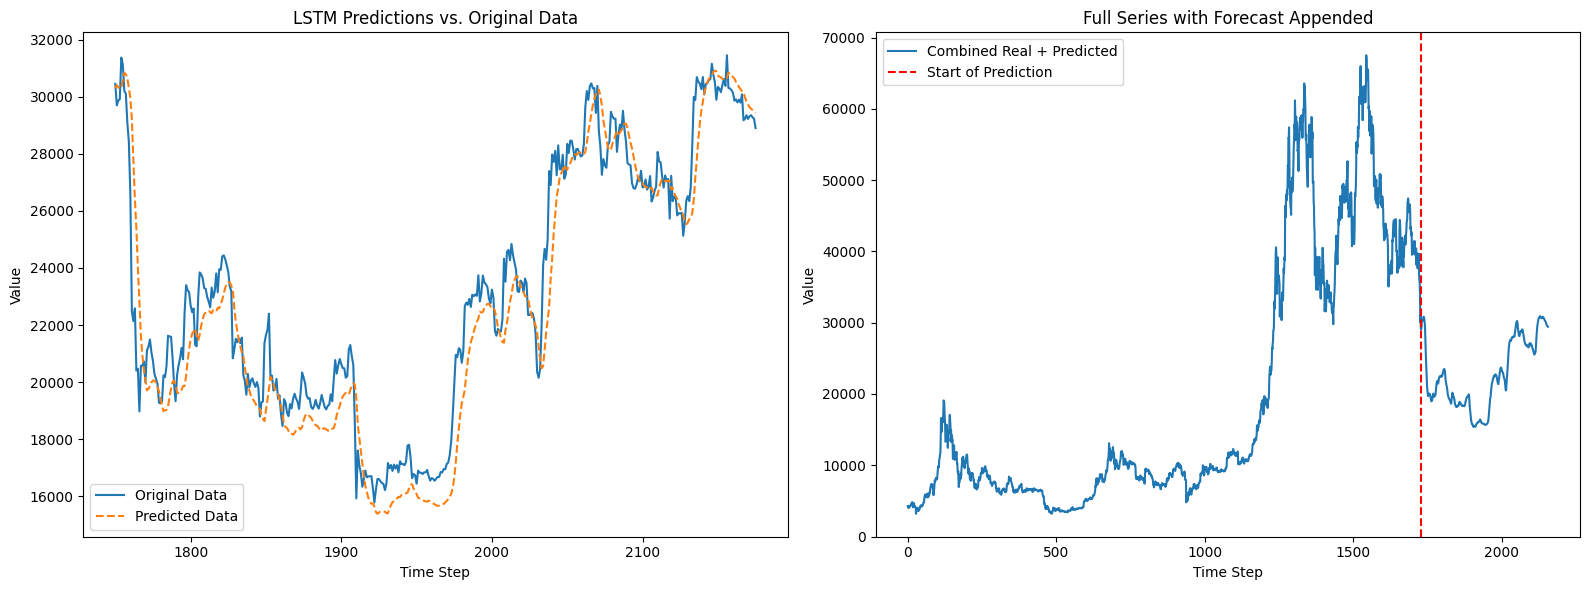

array([ 4285.08      ,  4108.37      ,  4139.98      , ...,
       29537.54918391, 29491.51175294, 29438.48439265])

In [46]:
model.eval()
with torch.no_grad():
    y_pred_test, _, _ = model(X_test)

y_pred_denorm = inverse_transform_single_column(y_pred_test, scaler, num_feat=5)

plot_lstm_forecast(y_pred_denorm, df_close.values, X_close_test, seq_length)

## Experimento - Mudança no hidden_dim

Mudança de hidden_dim para 200

In [47]:
# Hiperparâmetros
seq_length = 10
num_epochs = 1000
hidden_dim = 200
layer_dim = 1
learning_rate = 0.01
patience = 20

In [48]:
# cria sequências
X_train, Y_train = create_sequences(X_close_train, seq_length)
X_val, Y_val = create_sequences(X_close_val, seq_length)
X_test, Y_test = create_sequences(X_close_test, seq_length)

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

torch.Size([1513, 10, 1])
torch.Size([207, 10, 1])
torch.Size([426, 10, 1])


In [49]:
model = LSTMModel(input_dim=1, hidden_dim=hidden_dim, layer_dim=layer_dim, output_dim=1)
model.to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [50]:
train_lstm(model, criterion, optimizer, X_train, Y_train, X_val, Y_val, num_epochs, patience=patience)

Época 1/1000 — Train Loss: 0.1096 — Val Loss: 0.1115 — Streak: 0/20
Época 10/1000 — Train Loss: 0.0401 — Val Loss: 0.1431 — Streak: 4/20
Época 20/1000 — Train Loss: 0.0119 — Val Loss: 0.0283 — Streak: 6/20
Época 30/1000 — Train Loss: 0.0025 — Val Loss: 0.0089 — Streak: 16/20
--> Early stopping na época 34. Melhor Val Loss: 0.0013


(LSTMModel(
   (lstm): LSTM(1, 200, batch_first=True)
   (fc): Linear(in_features=200, out_features=1, bias=True)
 ),
 tensor(0.0013, device='cuda:0'))

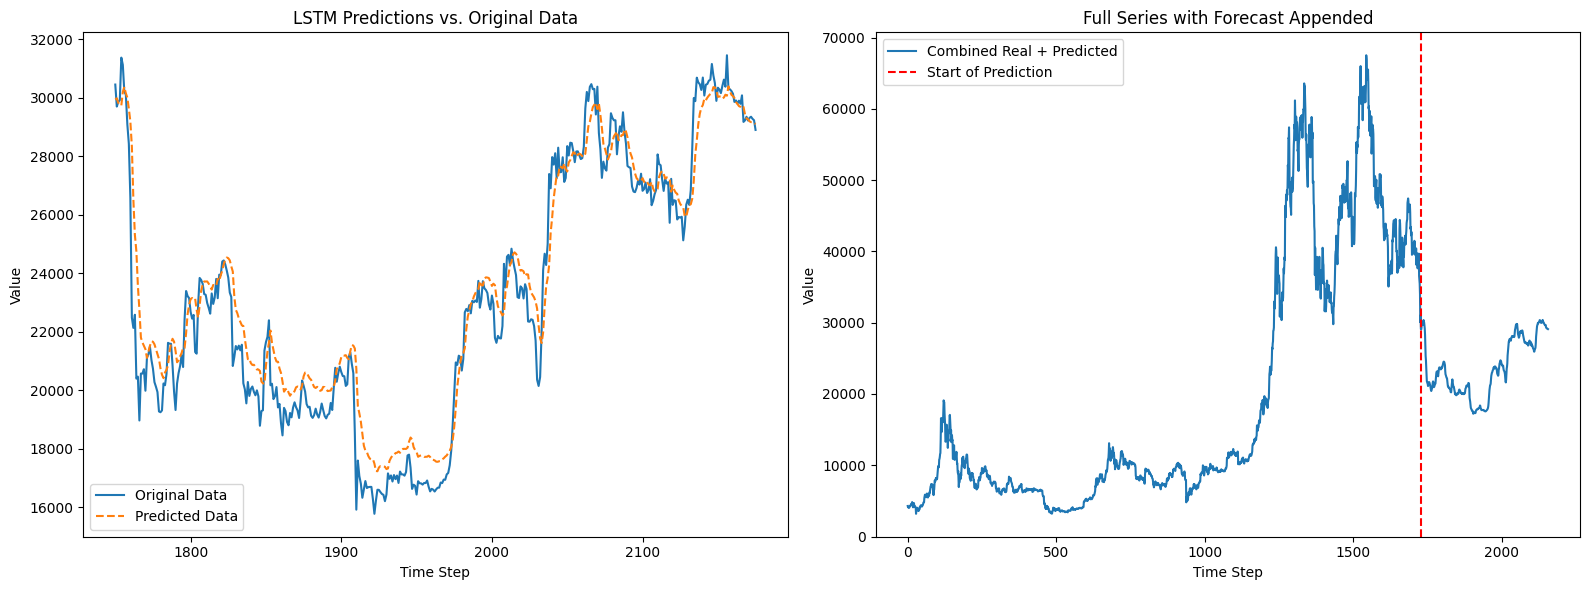

array([ 4285.08      ,  4108.37      ,  4139.98      , ...,
       29169.07696755, 29141.44839008, 29103.6948532 ])

In [51]:
model.eval()
with torch.no_grad():
    y_pred_test, _, _ = model(X_test)

y_pred_denorm = inverse_transform_single_column(y_pred_test, scaler, num_feat=5)

plot_lstm_forecast(y_pred_denorm, df_close.values, X_close_test, seq_length)

## Experimento - Mudança no layer_dim

Mudança de hidden_dim para 3

In [52]:
# Hiperparâmetros
seq_length = 10
num_epochs = 1000
hidden_dim = 100
layer_dim = 3
learning_rate = 0.01
patience = 20

In [53]:
# cria sequências
X_train, Y_train = create_sequences(X_close_train, seq_length)
X_val, Y_val = create_sequences(X_close_val, seq_length)
X_test, Y_test = create_sequences(X_close_test, seq_length)

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

torch.Size([1513, 10, 1])
torch.Size([207, 10, 1])
torch.Size([426, 10, 1])


In [54]:
model = LSTMModel(input_dim=1, hidden_dim=hidden_dim, layer_dim=layer_dim, output_dim=1)
model.to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [55]:
train_lstm(model, criterion, optimizer, X_train, Y_train, X_val, Y_val, num_epochs, patience=patience)

Época 1/1000 — Train Loss: 0.0808 — Val Loss: 0.0741 — Streak: 0/20
Época 10/1000 — Train Loss: 0.0398 — Val Loss: 0.0066 — Streak: 0/20
Época 20/1000 — Train Loss: 0.0055 — Val Loss: 0.0189 — Streak: 10/20
Época 30/1000 — Train Loss: 0.0069 — Val Loss: 0.0186 — Streak: 20/20
--> Early stopping na época 30. Melhor Val Loss: 0.0066


(LSTMModel(
   (lstm): LSTM(1, 100, num_layers=3, batch_first=True)
   (fc): Linear(in_features=100, out_features=1, bias=True)
 ),
 tensor(0.0066, device='cuda:0'))

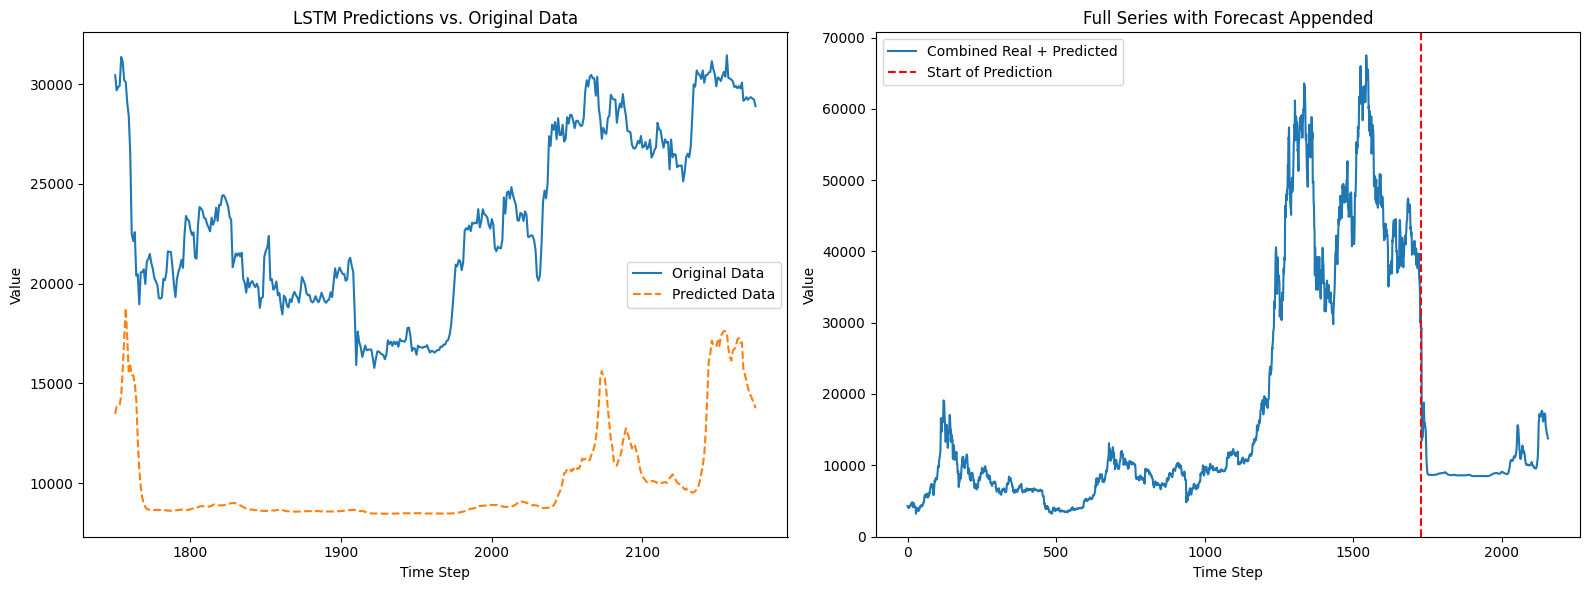

array([ 4285.08      ,  4108.37      ,  4139.98      , ...,
       14175.44282238, 14030.31360505, 13758.67188611])

In [56]:
model.eval()
with torch.no_grad():
    y_pred_test, _, _ = model(X_test)

y_pred_denorm = inverse_transform_single_column(y_pred_test, scaler, num_feat=5)

plot_lstm_forecast(y_pred_denorm, df_close.values, X_close_test, seq_length)

## Experimento - Mudança no otimizador

Mudança para SGD

In [57]:
# Hiperparâmetros
seq_length = 10
num_epochs = 1000
hidden_dim = 100
layer_dim = 1
learning_rate = 0.01
patience = 20

In [58]:
# cria sequências
X_train, Y_train = create_sequences(X_close_train, seq_length)
X_val, Y_val = create_sequences(X_close_val, seq_length)
X_test, Y_test = create_sequences(X_close_test, seq_length)

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

torch.Size([1513, 10, 1])
torch.Size([207, 10, 1])
torch.Size([426, 10, 1])


In [59]:
model = LSTMModel(input_dim=1, hidden_dim=hidden_dim, layer_dim=layer_dim, output_dim=1)
model.to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [60]:
train_lstm(model, criterion, optimizer, X_train, Y_train, X_val, Y_val, num_epochs, patience=patience)

Época 1/1000 — Train Loss: 0.1530 — Val Loss: 0.6133 — Streak: 0/20
Época 10/1000 — Train Loss: 0.1171 — Val Loss: 0.5152 — Streak: 0/20
Época 20/1000 — Train Loss: 0.0933 — Val Loss: 0.4379 — Streak: 0/20
Época 30/1000 — Train Loss: 0.0794 — Val Loss: 0.3830 — Streak: 0/20
Época 40/1000 — Train Loss: 0.0713 — Val Loss: 0.3435 — Streak: 0/20
Época 50/1000 — Train Loss: 0.0665 — Val Loss: 0.3147 — Streak: 0/20
Época 60/1000 — Train Loss: 0.0636 — Val Loss: 0.2934 — Streak: 0/20
Época 70/1000 — Train Loss: 0.0618 — Val Loss: 0.2774 — Streak: 0/20
Época 80/1000 — Train Loss: 0.0607 — Val Loss: 0.2653 — Streak: 0/20
Época 90/1000 — Train Loss: 0.0599 — Val Loss: 0.2561 — Streak: 0/20
Época 100/1000 — Train Loss: 0.0593 — Val Loss: 0.2488 — Streak: 0/20
Época 110/1000 — Train Loss: 0.0589 — Val Loss: 0.2432 — Streak: 0/20
Época 120/1000 — Train Loss: 0.0585 — Val Loss: 0.2386 — Streak: 0/20
Época 130/1000 — Train Loss: 0.0581 — Val Loss: 0.2349 — Streak: 0/20
Época 140/1000 — Train Loss: 0.

(LSTMModel(
   (lstm): LSTM(1, 100, batch_first=True)
   (fc): Linear(in_features=100, out_features=1, bias=True)
 ),
 tensor(0.1096, device='cuda:0'))

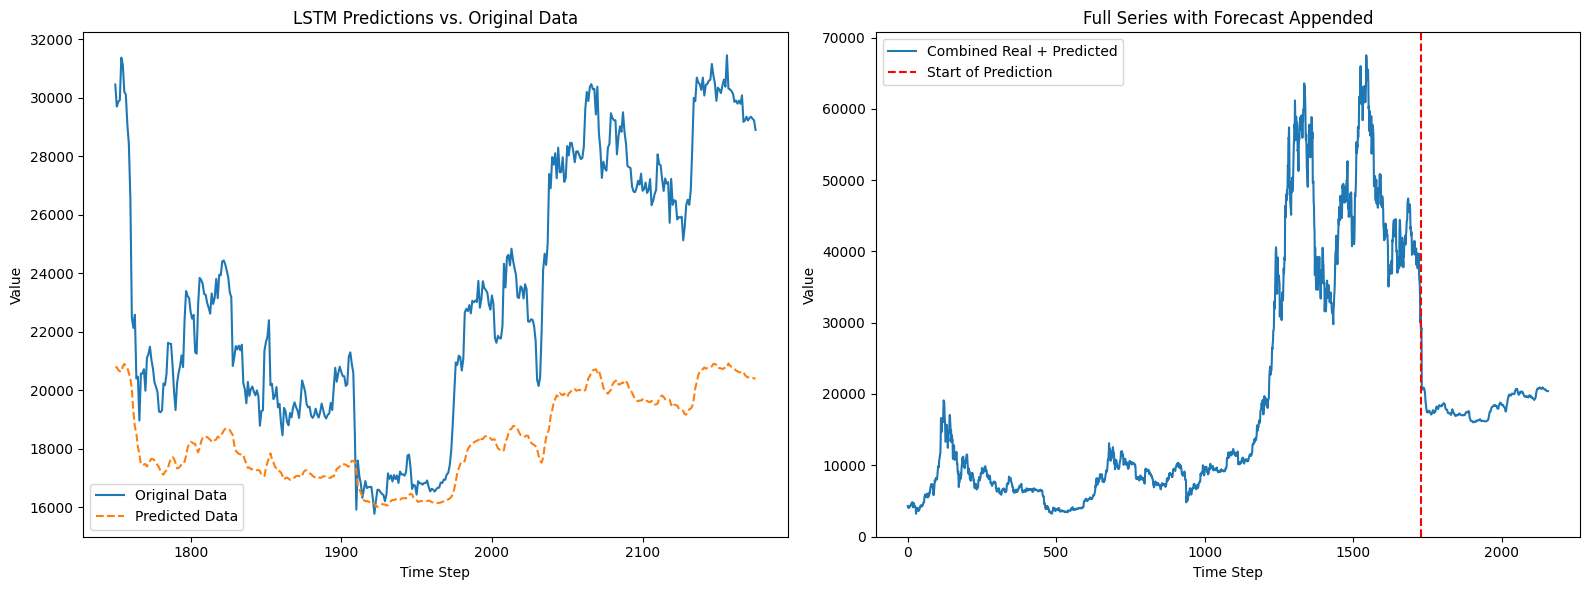

array([ 4285.08      ,  4108.37      ,  4139.98      , ...,
       20420.27878944, 20412.24864922, 20400.7595378 ])

In [61]:
model.eval()
with torch.no_grad():
    y_pred_test, _, _ = model(X_test)

y_pred_denorm = inverse_transform_single_column(y_pred_test, scaler, num_feat=5)

plot_lstm_forecast(y_pred_denorm, df_close.values, X_close_test, seq_length)

## Experimento - Dropout = 0.2

In [62]:
# Hiperparâmetros
seq_length = 10
num_epochs = 1000
hidden_dim = 100
layer_dim = 1
learning_rate = 0.01
patience = 20
dropout = 0.2

In [63]:
# cria sequências
X_train, Y_train = create_sequences(X_close_train, seq_length)
X_val, Y_val = create_sequences(X_close_val, seq_length)
X_test, Y_test = create_sequences(X_close_test, seq_length)

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

torch.Size([1513, 10, 1])
torch.Size([207, 10, 1])
torch.Size([426, 10, 1])


In [64]:
model = LSTMModel(input_dim=1, hidden_dim=hidden_dim, layer_dim=layer_dim, output_dim=1, dropout=dropout)
model.to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [65]:
train_lstm(model, criterion, optimizer, X_train, Y_train, X_val, Y_val, num_epochs, patience=patience)

Época 1/1000 — Train Loss: 0.1057 — Val Loss: 0.2079 — Streak: 0/20
Época 10/1000 — Train Loss: 0.0421 — Val Loss: 0.1441 — Streak: 8/20
Época 20/1000 — Train Loss: 0.0059 — Val Loss: 0.0339 — Streak: 5/20
Época 30/1000 — Train Loss: 0.0036 — Val Loss: 0.0029 — Streak: 3/20
Época 40/1000 — Train Loss: 0.0016 — Val Loss: 0.0041 — Streak: 13/20
Época 50/1000 — Train Loss: 0.0008 — Val Loss: 0.0018 — Streak: 8/20
Época 60/1000 — Train Loss: 0.0006 — Val Loss: 0.0021 — Streak: 18/20
--> Early stopping na época 62. Melhor Val Loss: 0.0012


(LSTMModel(
   (lstm): LSTM(1, 100, batch_first=True)
   (fc): Linear(in_features=100, out_features=1, bias=True)
 ),
 tensor(0.0012, device='cuda:0'))

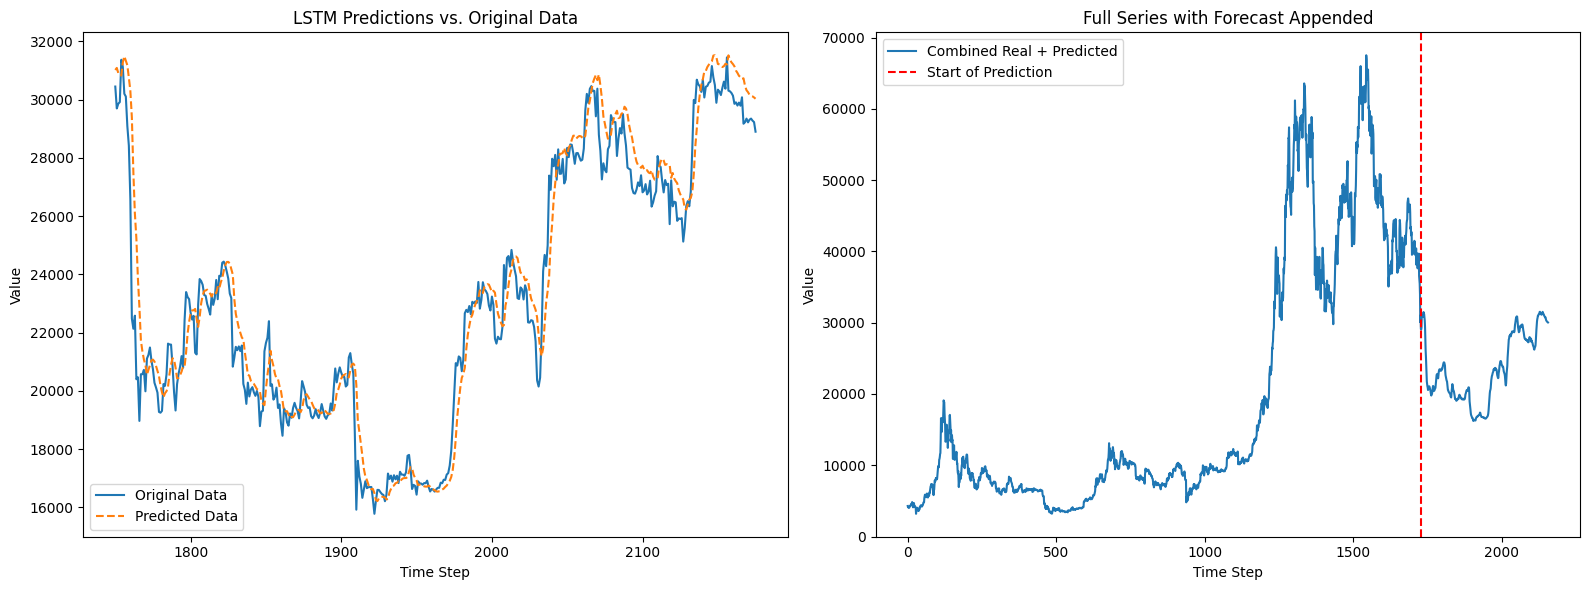

array([ 4285.08      ,  4108.37      ,  4139.98      , ...,
       30115.11818911, 30078.62802256, 30034.41725952])

In [66]:
model.eval()
with torch.no_grad():
    y_pred_test, _, _ = model(X_test)

y_pred_denorm = inverse_transform_single_column(y_pred_test, scaler, num_feat=5)

plot_lstm_forecast(y_pred_denorm, df_close.values, X_close_test, seq_length)

### Previsão Multi-Step

In [67]:
last_window = X_train[-1].unsqueeze(0)  # (1, seq_length, input_dim)

# roda a previsão multi-step
future_preds = forecast_n_steps(
    model=model,
    last_window=last_window,
    n_steps=30,
    input_dim=1
)

y_pred_denorm = inverse_transform_single_column(future_preds, scaler, num_feat=5)

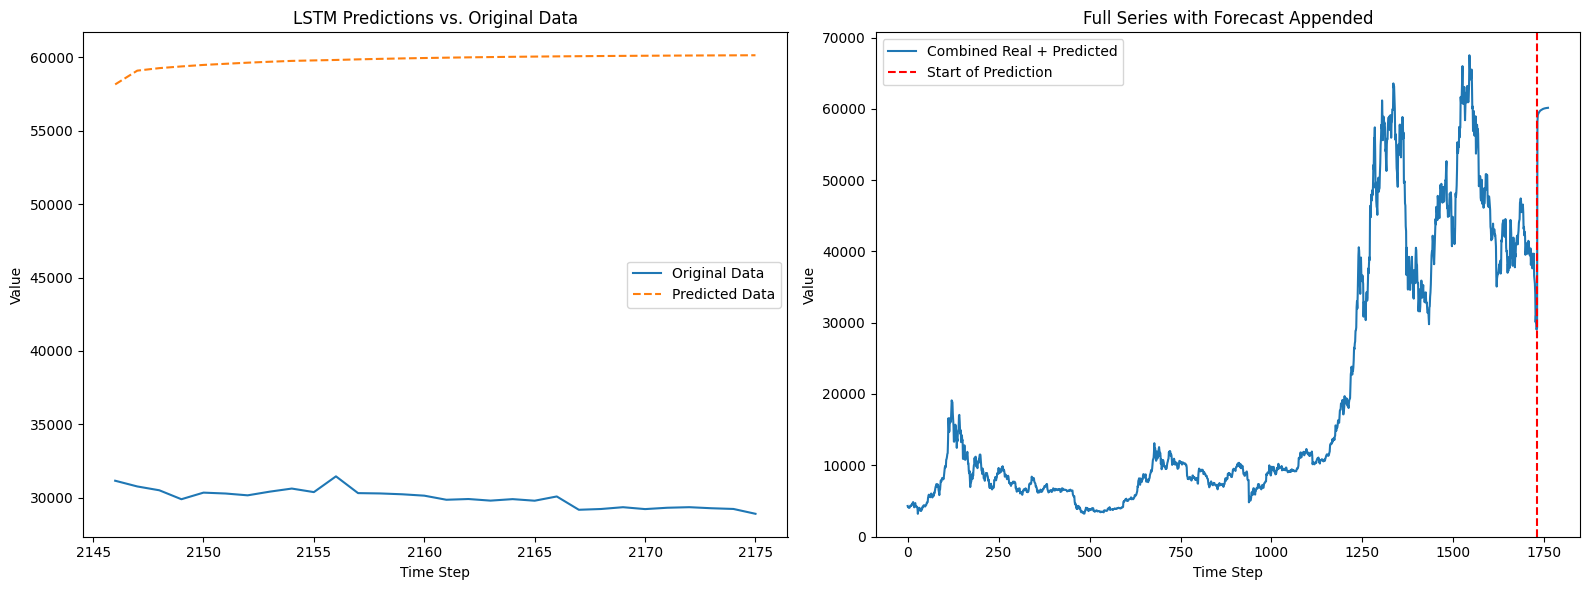

array([ 4285.08      ,  4108.37      ,  4139.98      , ...,
       60141.01465733, 60146.90318687, 60152.18342699])

In [68]:
plot_lstm_forecast(y_pred_denorm, df_close.values, X_close_test, seq_length)

## Experimento - Dropout = 0.5

In [69]:
# Hiperparâmetros
seq_length = 10
num_epochs = 1000
hidden_dim = 100
layer_dim = 1
learning_rate = 0.01
patience = 20
dropout = 0.5

In [70]:
# cria sequências
X_train, Y_train = create_sequences(X_close_train, seq_length)
X_val, Y_val = create_sequences(X_close_val, seq_length)
X_test, Y_test = create_sequences(X_close_test, seq_length)

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

torch.Size([1513, 10, 1])
torch.Size([207, 10, 1])
torch.Size([426, 10, 1])


In [71]:
model = LSTMModel(input_dim=1, hidden_dim=hidden_dim, layer_dim=layer_dim, output_dim=1, dropout=dropout)
model.to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [72]:
train_lstm(model, criterion, optimizer, X_train, Y_train, X_val, Y_val, num_epochs, patience=patience)

Época 1/1000 — Train Loss: 0.0759 — Val Loss: 0.1556 — Streak: 0/20
Época 10/1000 — Train Loss: 0.0116 — Val Loss: 0.0209 — Streak: 4/20
Época 20/1000 — Train Loss: 0.0011 — Val Loss: 0.0031 — Streak: 5/20
Época 30/1000 — Train Loss: 0.0021 — Val Loss: 0.0050 — Streak: 8/20
Época 40/1000 — Train Loss: 0.0008 — Val Loss: 0.0014 — Streak: 18/20
--> Early stopping na época 42. Melhor Val Loss: 0.0014


(LSTMModel(
   (lstm): LSTM(1, 100, batch_first=True)
   (fc): Linear(in_features=100, out_features=1, bias=True)
 ),
 tensor(0.0014, device='cuda:0'))

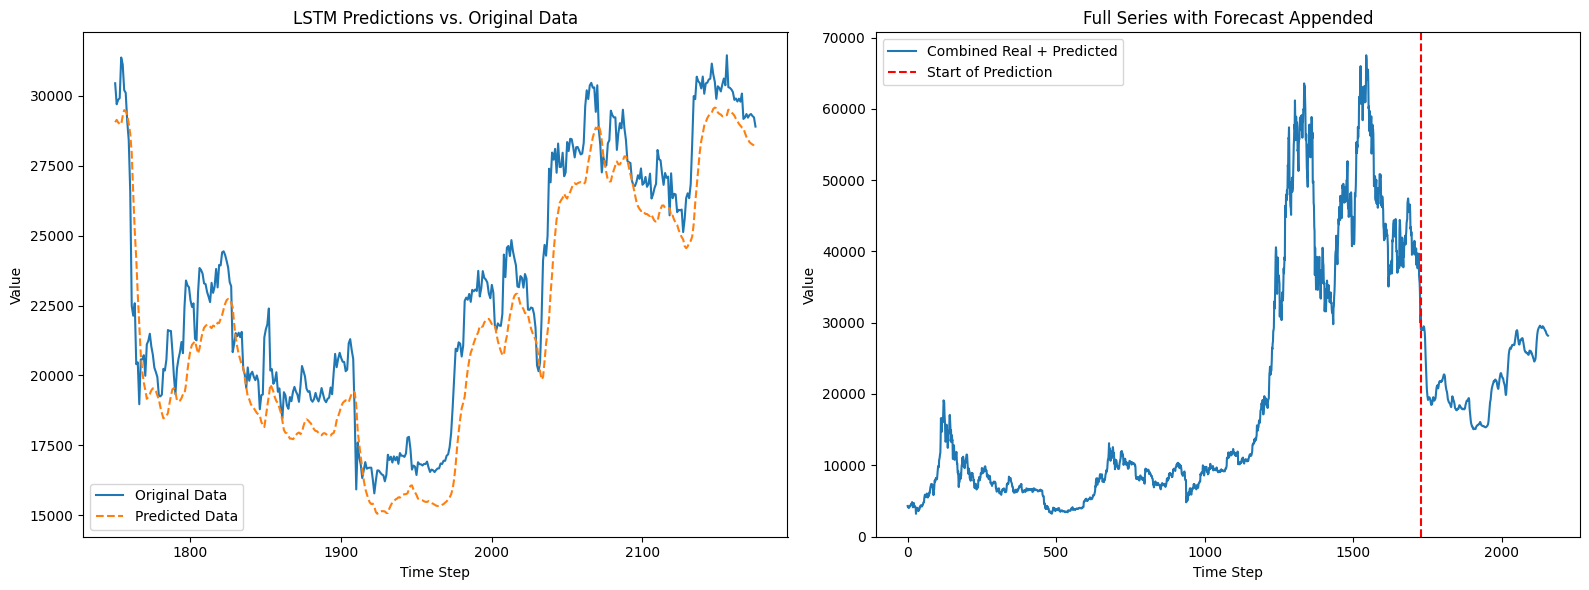

array([ 4285.08      ,  4108.37      ,  4139.98      , ...,
       28264.25005374, 28226.341745  , 28181.65226899])

In [73]:
model.eval()
with torch.no_grad():
    y_pred_test, _, _ = model(X_test)

y_pred_denorm = inverse_transform_single_column(y_pred_test, scaler, num_feat=5)

plot_lstm_forecast(y_pred_denorm, df_close.values, X_close_test, seq_length)

### Previsão Multi-Step

In [74]:
last_window = X_train[-1].unsqueeze(0)  # (1, seq_length, input_dim)

# roda a previsão multi-step
future_preds = forecast_n_steps(
    model=model,
    last_window=last_window,
    n_steps=30,
    input_dim=1
)

y_pred_denorm = inverse_transform_single_column(future_preds, scaler, num_feat=5)

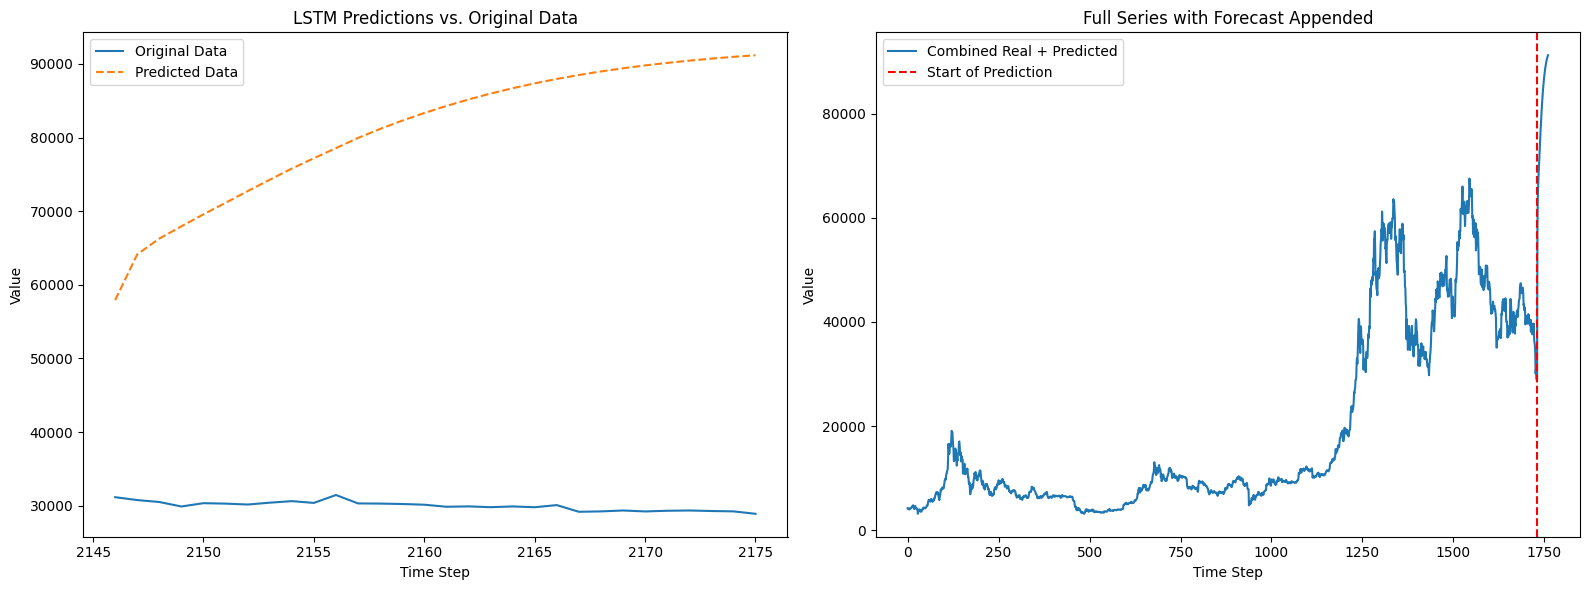

array([ 4285.08      ,  4108.37      ,  4139.98      , ...,
       90724.70172621, 90967.16085018, 91182.32973517])

In [75]:
plot_lstm_forecast(y_pred_denorm, df_close.values, X_close_test, seq_length)

## Experimento - Clip-margin = 1

In [143]:
# Hiperparâmetros
seq_length = 10
num_epochs = 1000
hidden_dim = 100
layer_dim = 1
learning_rate = 0.01
patience = 20
clip_margin = 1

In [144]:
def train_lstm_clip_margin(model, criterion, optimizer,
                          trainX, trainY, valX, valY,
                          num_epochs=100, patience=10, min_delta=1e-4):
    best_val_loss = float('inf')
    epochs_no_improve = 0
    best_model_state = None

    for epoch in range(1, num_epochs+1):
        # ---- Treino ----
        model.train()
        optimizer.zero_grad()
        outputs, h0, c0 = model(trainX)
        loss = criterion(outputs, trainY)
        loss.backward()


        parameters = [p for p in model.parameters() if p.grad is not None]
        total_norm = torch.norm(torch.stack([p.grad.detach().norm(2) for p in parameters]), 2).item()
        print(f"Grad norm before clip: {total_norm:.4f}")

        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=clip_margin)

        total_norm_after = torch.norm(torch.stack([p.grad.detach().norm(2) for p in parameters]), 2).item()
        print(f"Grad norm after clip: {total_norm_after:.4f}")
        optimizer.step()

        # ---- Validação ----
        model.eval()
        with torch.no_grad():
            val_outputs, _, _ = model(valX)
            val_loss = criterion(val_outputs, valY)

        # ---- Checa melhoria ----
        if val_loss < best_val_loss - min_delta:
            best_val_loss = val_loss
            epochs_no_improve = 0
            best_model_state = model.state_dict()  # guarda melhor modelo
        else:
            epochs_no_improve += 1

        # ---- Log ----
        if epoch % 10 == 0 or epoch == 1:
            print(f'Época {epoch}/{num_epochs} — '
                  f'Train Loss: {loss.item():.4f} — '
                  f'Val Loss: {val_loss.item():.4f} — '
                  f'Streak: {epochs_no_improve}/{patience}')

        # ---- Early Stopping ----
        if epochs_no_improve >= patience:
            print(f'--> Early stopping na época {epoch}. '
                  f'Melhor Val Loss: {best_val_loss:.4f}')
            break

    # Restaura pesos do melhor modelo
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
    return model


In [145]:
# cria sequências
X_train, Y_train = create_sequences(X_close_train, seq_length)
X_val, Y_val = create_sequences(X_close_val, seq_length)
X_test, Y_test = create_sequences(X_close_test, seq_length)

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

torch.Size([1513, 10, 1])
torch.Size([207, 10, 1])
torch.Size([426, 10, 1])


In [146]:
model = LSTMModel(input_dim=1, hidden_dim=hidden_dim, layer_dim=layer_dim, output_dim=1)
model.to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [147]:
train_lstm_clip_margin(model, criterion, optimizer, X_train, Y_train, X_val, Y_val, num_epochs, patience=patience)

Grad norm before clip: 0.4844
Grad norm after clip: 0.4844
Época 1/1000 — Train Loss: 0.1076 — Val Loss: 0.2357 — Streak: 0/20
Grad norm before clip: 0.0715
Grad norm after clip: 0.0715
Grad norm before clip: 0.8062
Grad norm after clip: 0.8062
Grad norm before clip: 0.0655
Grad norm after clip: 0.0655
Grad norm before clip: 0.2425
Grad norm after clip: 0.2425
Grad norm before clip: 0.2962
Grad norm after clip: 0.2962
Grad norm before clip: 0.2758
Grad norm after clip: 0.2758
Grad norm before clip: 0.2156
Grad norm after clip: 0.2156
Grad norm before clip: 0.1234
Grad norm after clip: 0.1234
Grad norm before clip: 0.1175
Grad norm after clip: 0.1175
Época 10/1000 — Train Loss: 0.0207 — Val Loss: 0.0032 — Streak: 0/20
Grad norm before clip: 0.4394
Grad norm after clip: 0.4394
Grad norm before clip: 0.4014
Grad norm after clip: 0.4014
Grad norm before clip: 0.1282
Grad norm after clip: 0.1282
Grad norm before clip: 0.0968
Grad norm after clip: 0.0968
Grad norm before clip: 0.1867
Grad no

LSTMModel(
  (lstm): LSTM(1, 100, batch_first=True)
  (fc): Linear(in_features=100, out_features=1, bias=True)
)

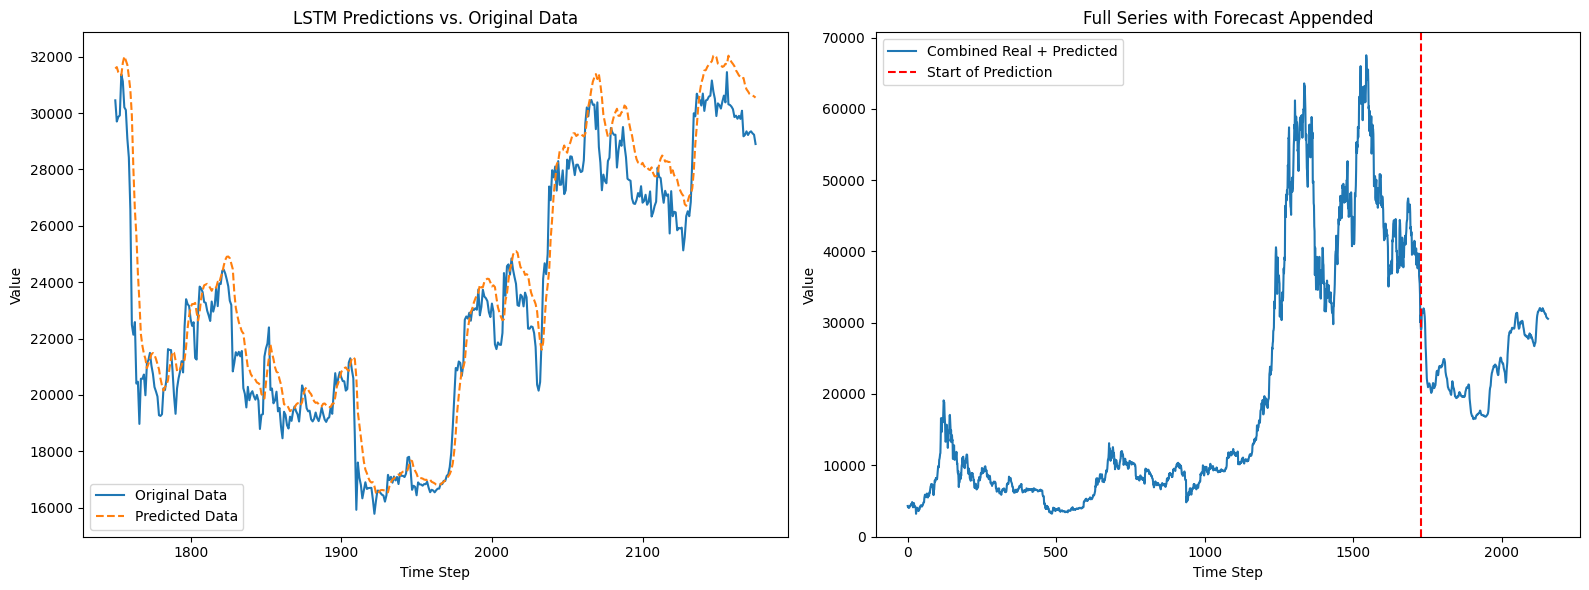

array([ 4285.08      ,  4108.37      ,  4139.98      , ...,
       30626.36385105, 30592.25465168, 30549.5376171 ])

In [148]:
model.eval()
with torch.no_grad():
    y_pred_test, _, _ = model(X_test)

y_pred_denorm = inverse_transform_single_column(y_pred_test, scaler, num_feat=5)

plot_lstm_forecast(y_pred_denorm, df_close.values, X_close_test, seq_length)

### Previsão Multi-Step

In [149]:
last_window = X_train[-1].unsqueeze(0)  # (1, seq_length, input_dim)

# roda a previsão multi-step
future_preds = forecast_n_steps(
    model=model,
    last_window=last_window,
    n_steps=30,
    input_dim=1
)

y_pred_denorm = inverse_transform_single_column(future_preds, scaler, num_feat=5)

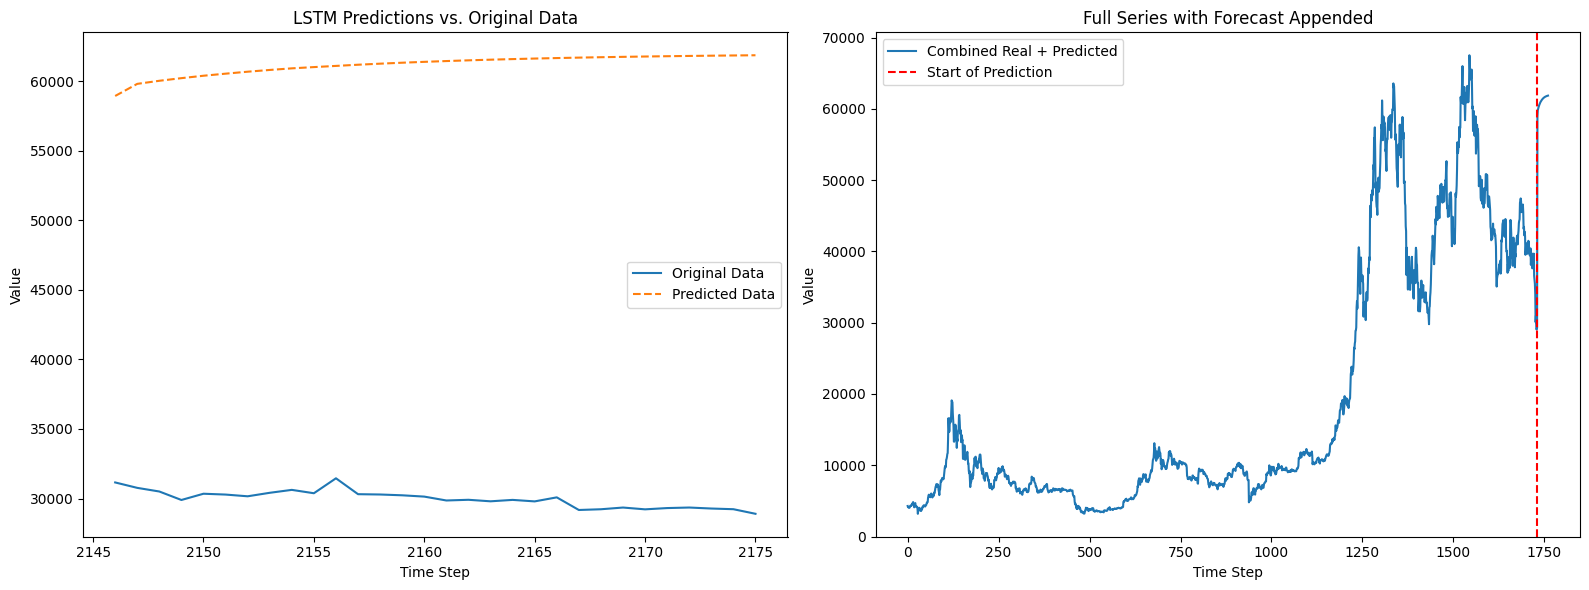

array([ 4285.08      ,  4108.37      ,  4139.98      , ...,
       61832.84390397, 61849.08775104, 61863.82707162])

In [150]:
plot_lstm_forecast(y_pred_denorm, df_close.values, X_close_test, seq_length)

## Experimento - Clip-margin = 0.5

In [151]:
# Hiperparâmetros
seq_length = 10
num_epochs = 1000
hidden_dim = 100
layer_dim = 1
learning_rate = 0.01
patience = 20
clip_margin = 0.5

In [152]:
# cria sequências
X_train, Y_train = create_sequences(X_close_train, seq_length)
X_val, Y_val = create_sequences(X_close_val, seq_length)
X_test, Y_test = create_sequences(X_close_test, seq_length)

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

torch.Size([1513, 10, 1])
torch.Size([207, 10, 1])
torch.Size([426, 10, 1])


In [153]:
model = LSTMModel(input_dim=1, hidden_dim=hidden_dim, layer_dim=layer_dim, output_dim=1)
model.to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [154]:
train_lstm_clip_margin(model, criterion, optimizer, X_train, Y_train, X_val, Y_val, num_epochs, patience=patience)

Grad norm before clip: 0.5673
Grad norm after clip: 0.5000
Época 1/1000 — Train Loss: 0.1188 — Val Loss: 0.2214 — Streak: 0/20
Grad norm before clip: 0.0779
Grad norm after clip: 0.0779
Grad norm before clip: 1.4100
Grad norm after clip: 0.5000
Grad norm before clip: 0.1360
Grad norm after clip: 0.1360
Grad norm before clip: 0.2151
Grad norm after clip: 0.2151
Grad norm before clip: 0.2826
Grad norm after clip: 0.2826
Grad norm before clip: 0.2594
Grad norm after clip: 0.2594
Grad norm before clip: 0.1799
Grad norm after clip: 0.1799
Grad norm before clip: 0.0703
Grad norm after clip: 0.0703
Grad norm before clip: 0.2903
Grad norm after clip: 0.2903
Época 10/1000 — Train Loss: 0.0228 — Val Loss: 0.0060 — Streak: 0/20
Grad norm before clip: 0.4886
Grad norm after clip: 0.4886
Grad norm before clip: 0.2149
Grad norm after clip: 0.2149
Grad norm before clip: 0.0730
Grad norm after clip: 0.0730
Grad norm before clip: 0.1998
Grad norm after clip: 0.1998
Grad norm before clip: 0.2345
Grad no

LSTMModel(
  (lstm): LSTM(1, 100, batch_first=True)
  (fc): Linear(in_features=100, out_features=1, bias=True)
)

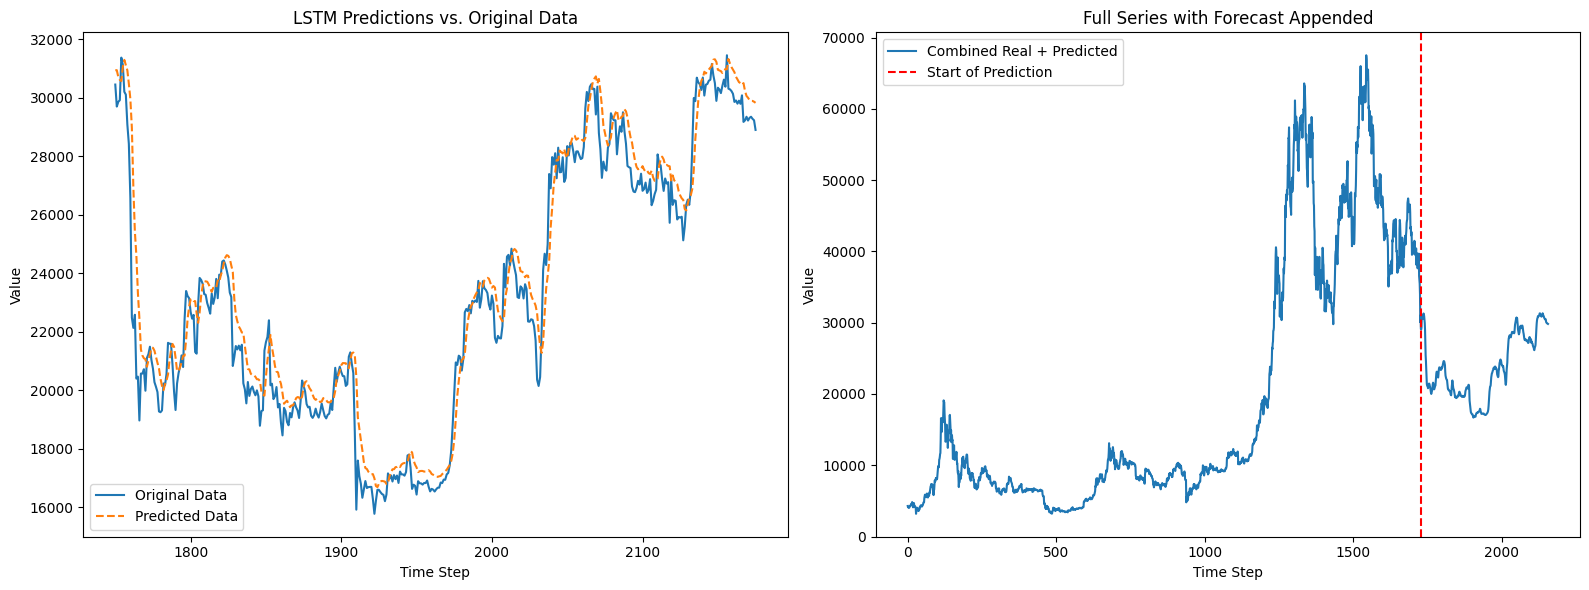

array([ 4285.08      ,  4108.37      ,  4139.98      , ...,
       29892.8531941 , 29865.90489296, 29828.72545172])

In [155]:
model.eval()
with torch.no_grad():
    y_pred_test, _, _ = model(X_test)

y_pred_denorm = inverse_transform_single_column(y_pred_test, scaler, num_feat=5)

plot_lstm_forecast(y_pred_denorm, df_close.values, X_close_test, seq_length)

### Previsão Multi-Step

In [156]:
last_window = X_train[-1].unsqueeze(0)  # (1, seq_length, input_dim)

# roda a previsão multi-step
future_preds = forecast_n_steps(
    model=model,
    last_window=last_window,
    n_steps=30,
    input_dim=1
)

y_pred_denorm = inverse_transform_single_column(future_preds, scaler, num_feat=5)

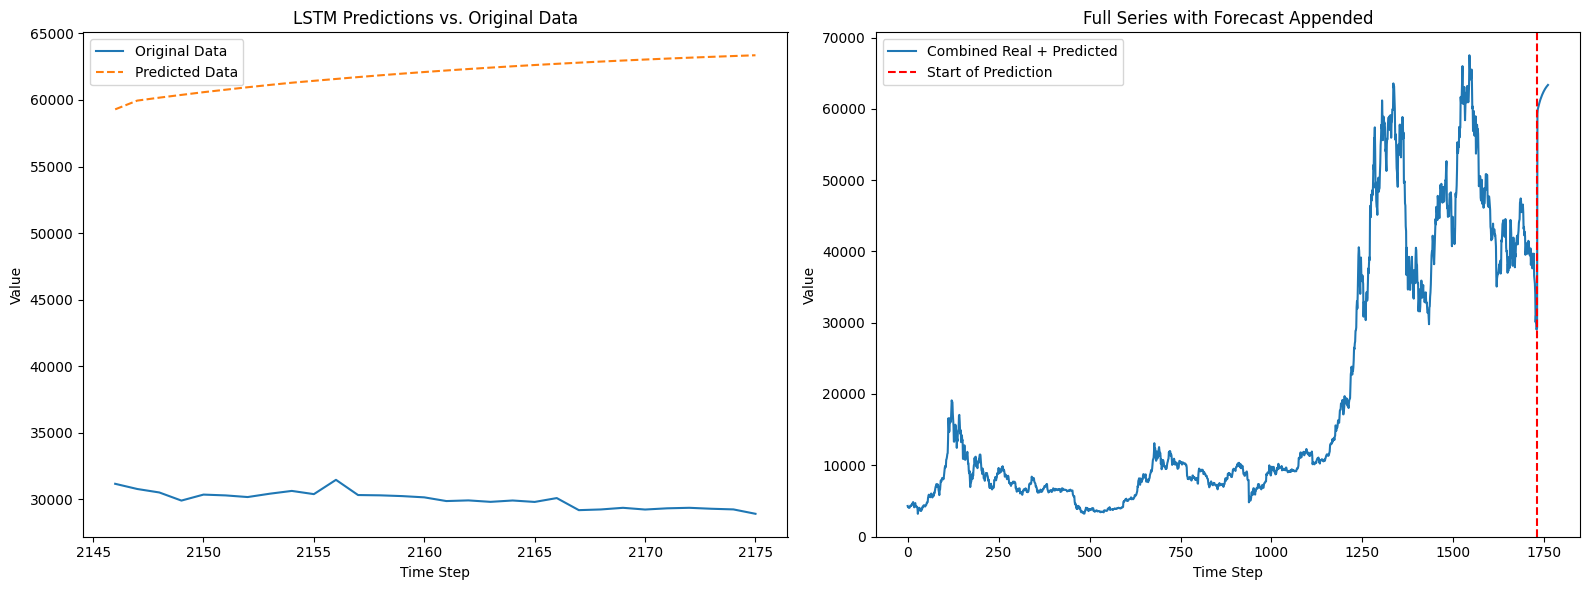

array([ 4285.08      ,  4108.37      ,  4139.98      , ...,
       63240.46521605, 63301.40213848, 63359.31561054])

In [157]:
plot_lstm_forecast(y_pred_denorm, df_close.values, X_close_test, seq_length)

## Experimento - Clip-margin = 0.2

In [164]:
# Hiperparâmetros
seq_length = 10
num_epochs = 1000
hidden_dim = 100
layer_dim = 1
learning_rate = 0.01
patience = 20
clip_margin = 3

In [165]:
# cria sequências
X_train, Y_train = create_sequences(X_close_train, seq_length)
X_val, Y_val = create_sequences(X_close_val, seq_length)
X_test, Y_test = create_sequences(X_close_test, seq_length)

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

torch.Size([1513, 10, 1])
torch.Size([207, 10, 1])
torch.Size([426, 10, 1])


In [166]:
model = LSTMModel(input_dim=1, hidden_dim=hidden_dim, layer_dim=layer_dim, output_dim=1)
model.to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [167]:
train_lstm_clip_margin(model, criterion, optimizer, X_train, Y_train, X_val, Y_val, num_epochs, patience=patience)

Grad norm before clip: 0.3387
Grad norm after clip: 0.3387
Época 1/1000 — Train Loss: 0.0818 — Val Loss: 0.1782 — Streak: 0/20
Grad norm before clip: 0.1024
Grad norm after clip: 0.1024
Grad norm before clip: 0.2134
Grad norm after clip: 0.2134
Grad norm before clip: 0.0852
Grad norm after clip: 0.0852
Grad norm before clip: 0.1515
Grad norm after clip: 0.1515
Grad norm before clip: 1.7552
Grad norm after clip: 1.7552
Grad norm before clip: 0.5573
Grad norm after clip: 0.5573
Grad norm before clip: 0.5827
Grad norm after clip: 0.5827
Grad norm before clip: 0.4332
Grad norm after clip: 0.4332
Grad norm before clip: 0.3059
Grad norm after clip: 0.3059
Época 10/1000 — Train Loss: 0.0442 — Val Loss: 0.1920 — Streak: 6/20
Grad norm before clip: 0.2114
Grad norm after clip: 0.2114
Grad norm before clip: 0.1396
Grad norm after clip: 0.1396
Grad norm before clip: 0.0871
Grad norm after clip: 0.0871
Grad norm before clip: 0.0687
Grad norm after clip: 0.0687
Grad norm before clip: 0.0952
Grad no

LSTMModel(
  (lstm): LSTM(1, 100, batch_first=True)
  (fc): Linear(in_features=100, out_features=1, bias=True)
)

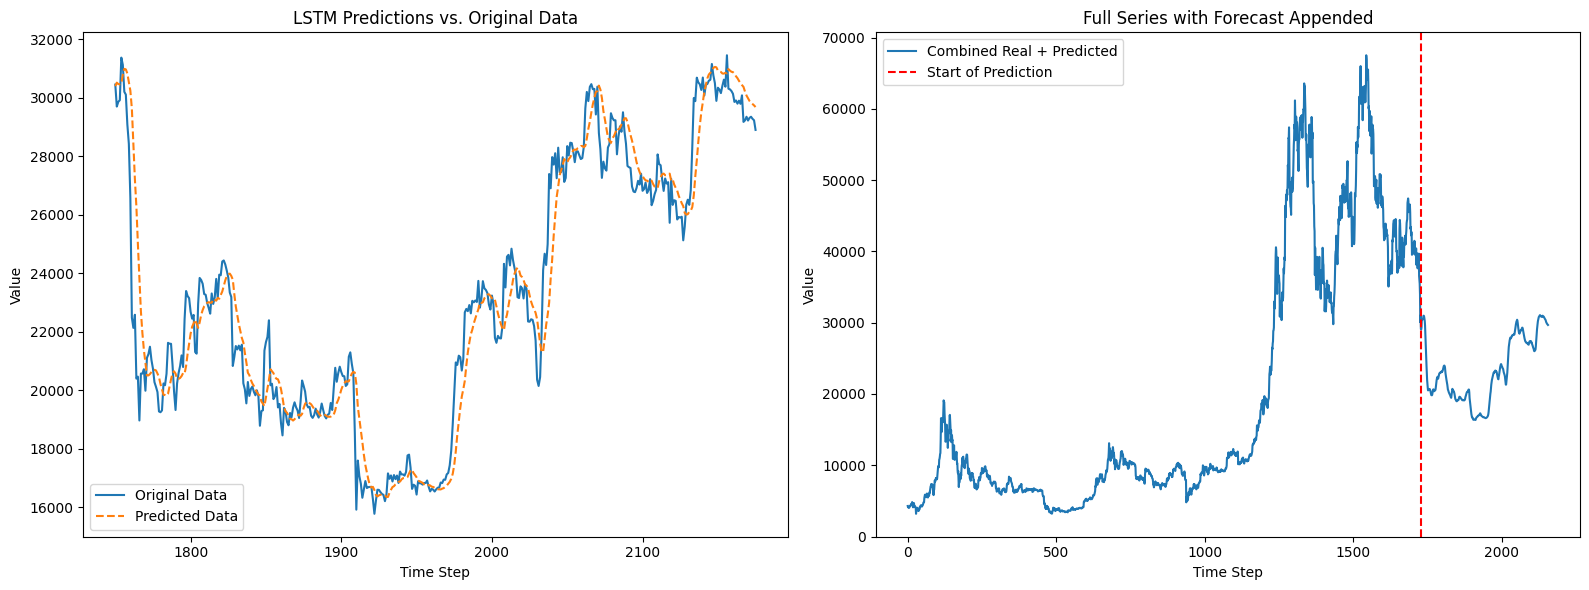

array([ 4285.08      ,  4108.37      ,  4139.98      , ...,
       29789.27302367, 29740.93921016, 29684.69403482])

In [168]:
model.eval()
with torch.no_grad():
    y_pred_test, _, _ = model(X_test)

y_pred_denorm = inverse_transform_single_column(y_pred_test, scaler, num_feat=5)

plot_lstm_forecast(y_pred_denorm, df_close.values, X_close_test, seq_length)

### Previsão Multi-Step

In [96]:
last_window = X_train[-1].unsqueeze(0)  # (1, seq_length, input_dim)

# roda a previsão multi-step
future_preds = forecast_n_steps(
    model=model,
    last_window=last_window,
    n_steps=30,
    input_dim=1
)

y_pred_denorm = inverse_transform_single_column(future_preds, scaler, num_feat=5)

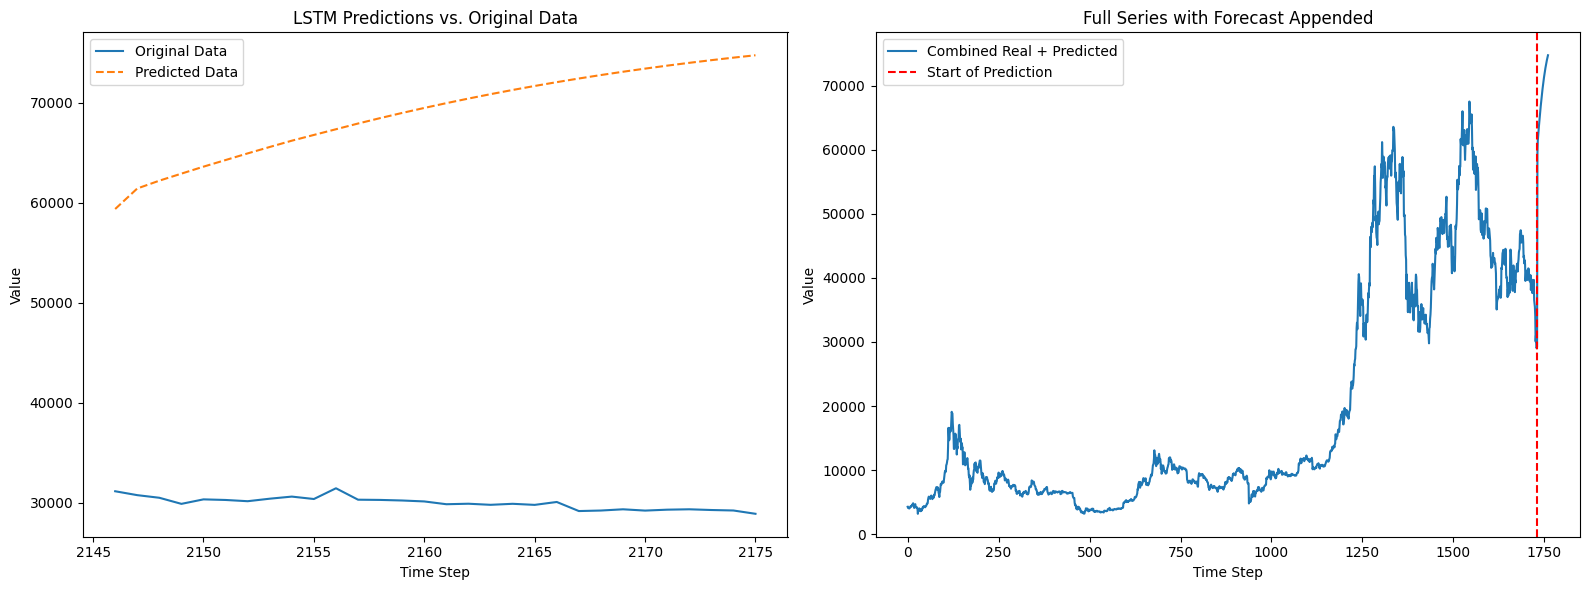

array([ 4285.08      ,  4108.37      ,  4139.98      , ...,
       74252.66333641, 74504.83349503, 74743.30454398])

In [97]:
plot_lstm_forecast(y_pred_denorm, df_close.values, X_close_test, seq_length)

## Experimento - Janela=50, Clip-margin=0.5, hidden_dim=200

In [169]:
# Hiperparâmetros
seq_length = 50
num_epochs = 1000
hidden_dim = 200
layer_dim = 1
learning_rate = 0.01
patience = 20
clip_margin = 0.5

In [170]:
# cria sequências
X_train, Y_train = create_sequences(X_close_train, seq_length)
X_val, Y_val = create_sequences(X_close_val, seq_length)
X_test, Y_test = create_sequences(X_close_test, seq_length)

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

torch.Size([1473, 50, 1])
torch.Size([167, 50, 1])
torch.Size([386, 50, 1])


In [171]:
model = LSTMModel(input_dim=1, hidden_dim=hidden_dim, layer_dim=layer_dim, output_dim=1)
model.to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [172]:
train_lstm_clip_margin(model, criterion, optimizer, X_train, Y_train, X_val, Y_val, num_epochs, patience=patience)

Grad norm before clip: 0.6693
Grad norm after clip: 0.5000
Época 1/1000 — Train Loss: 0.1436 — Val Loss: 0.0787 — Streak: 0/20
Grad norm before clip: 0.3233
Grad norm after clip: 0.3233
Grad norm before clip: 0.2914
Grad norm after clip: 0.2914
Grad norm before clip: 0.2579
Grad norm after clip: 0.2579
Grad norm before clip: 0.0937
Grad norm after clip: 0.0937
Grad norm before clip: 0.9825
Grad norm after clip: 0.5000
Grad norm before clip: 0.0705
Grad norm after clip: 0.0705
Grad norm before clip: 0.1699
Grad norm after clip: 0.1699
Grad norm before clip: 0.2088
Grad norm after clip: 0.2088
Grad norm before clip: 0.1811
Grad norm after clip: 0.1811
Época 10/1000 — Train Loss: 0.0321 — Val Loss: 0.0640 — Streak: 5/20
Grad norm before clip: 0.0924
Grad norm after clip: 0.0924
Grad norm before clip: 0.1854
Grad norm after clip: 0.1854
Grad norm before clip: 0.5166
Grad norm after clip: 0.5000
Grad norm before clip: 0.0396
Grad norm after clip: 0.0396
Grad norm before clip: 0.2390
Grad no

LSTMModel(
  (lstm): LSTM(1, 200, batch_first=True)
  (fc): Linear(in_features=200, out_features=1, bias=True)
)

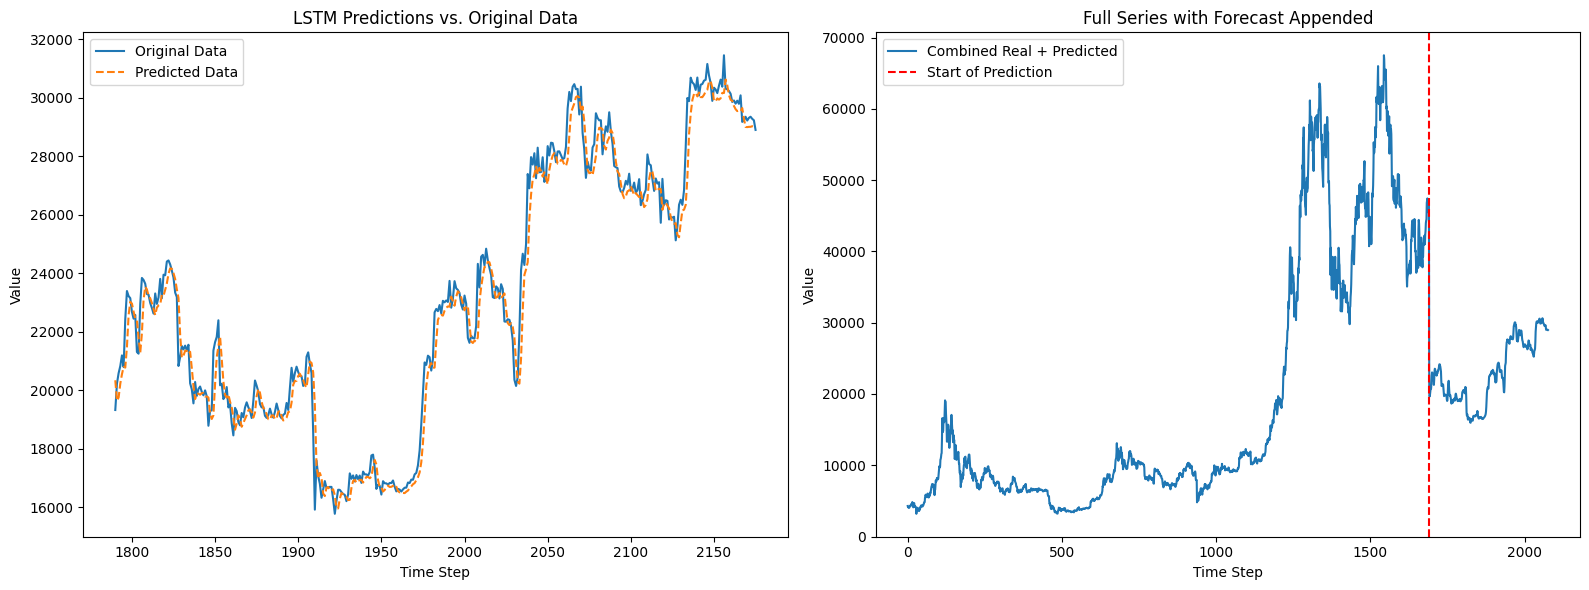

array([ 4285.08      ,  4108.37      ,  4139.98      , ...,
       29028.45773036, 29019.63033507, 28976.66674531])

In [173]:
model.eval()
with torch.no_grad():
    y_pred_test, _, _ = model(X_test)

y_pred_denorm = inverse_transform_single_column(y_pred_test, scaler, num_feat=5)

plot_lstm_forecast(y_pred_denorm, df_close.values, X_close_test, seq_length)

### Previsão Multi-Step

In [174]:
last_window = X_train[-1].unsqueeze(0)  # (1, seq_length, input_dim)

# roda a previsão multi-step
future_preds = forecast_n_steps(
    model=model,
    last_window=last_window,
    n_steps=30,
    input_dim=1
)

y_pred_denorm = inverse_transform_single_column(future_preds, scaler, num_feat=5)

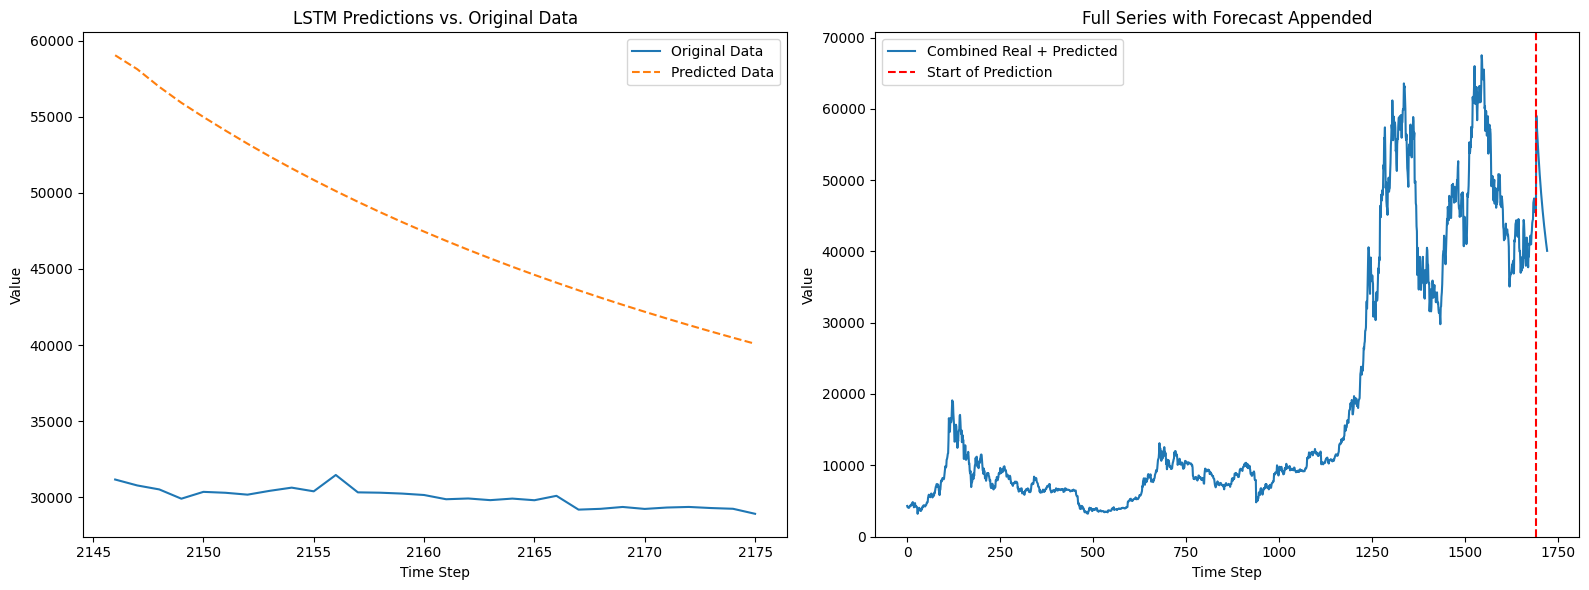

array([ 4285.08      ,  4108.37      ,  4139.98      , ...,
       40888.90644939, 40479.80841828, 40081.38604648])

In [175]:
plot_lstm_forecast(y_pred_denorm, df_close.values, X_close_test, seq_length)

## Experimento - Optuna

In [105]:
!pip install optuna
import optuna

def objective(trial):
    # 1) Sugestões de hiper-parâmetros
    seq_length  = trial.suggest_int("seq_length", 5, 50)
    hidden_dim  = trial.suggest_int("hidden_dim", 50, 200, step=25)
    layer_dim   = trial.suggest_int("layer_dim", 1, 5)
    learning_rate = trial.suggest_loguniform("lr", 1e-4, 1e-2)

    # 2) Prepara sequências com seq_length
    trainX, trainY = create_sequences(X_close_train, seq_length)
    valX,   valY   = create_sequences(X_close_val,   seq_length)

    # 3) Modelo, optimizer, critério
    model = LSTMModel(input_dim=1, hidden_dim=hidden_dim, layer_dim=layer_dim, output_dim=1)
    model.to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # 4) Treina e retorna val_loss
    _, val_loss = train_lstm(model, criterion, optimizer, trainX, trainY,
                             valX, valY, num_epochs=100, patience=10)
    return val_loss

# Cria estudo e roda
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)

print("Best params:", study.best_params)
print("Best val loss:", study.best_value)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.0/247.0 kB 23.2 MB/s eta 0:00:00


[I 2025-07-18 08:04:40,428] A new study created in memory with name: no-name-992fef3e-2278-4dd4-a572-d5af819bc4fe
/tmp/ipython-input-105-648355988.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("lr", 1e-4, 1e-2)


Época 1/100 — Train Loss: 0.0996 — Val Loss: 0.3294 — Streak: 0/10
Época 10/100 — Train Loss: 0.0632 — Val Loss: 0.2187 — Streak: 6/10
Época 20/100 — Train Loss: 0.0085 — Val Loss: 0.0304 — Streak: 2/10


[I 2025-07-18 08:04:42,534] Trial 0 finished with value: 0.004835112951695919 and parameters: {'seq_length': 36, 'hidden_dim': 100, 'layer_dim': 4, 'lr': 0.0016528880544382934}. Best is trial 0 with value: 0.004835112951695919.


--> Early stopping na época 28. Melhor Val Loss: 0.0048
Época 1/100 — Train Loss: 0.0867 — Val Loss: 0.2791 — Streak: 0/10
Época 10/100 — Train Loss: 0.0532 — Val Loss: 0.1514 — Streak: 4/10
Época 20/100 — Train Loss: 0.0035 — Val Loss: 0.0087 — Streak: 1/10
Época 30/100 — Train Loss: 0.0040 — Val Loss: 0.0048 — Streak: 2/10


[I 2025-07-18 08:04:43,038] Trial 1 finished with value: 0.0019429962849244475 and parameters: {'seq_length': 44, 'hidden_dim': 50, 'layer_dim': 2, 'lr': 0.002435940112116189}. Best is trial 1 with value: 0.0019429962849244475.


Época 40/100 — Train Loss: 0.0021 — Val Loss: 0.0055 — Streak: 6/10
--> Early stopping na época 44. Melhor Val Loss: 0.0019
Época 1/100 — Train Loss: 0.1474 — Val Loss: 0.5489 — Streak: 0/10
Época 10/100 — Train Loss: 0.1323 — Val Loss: 0.5086 — Streak: 0/10
Época 20/100 — Train Loss: 0.1172 — Val Loss: 0.4654 — Streak: 0/10
Época 30/100 — Train Loss: 0.1034 — Val Loss: 0.4219 — Streak: 0/10
Época 40/100 — Train Loss: 0.0904 — Val Loss: 0.3756 — Streak: 0/10
Época 50/100 — Train Loss: 0.0784 — Val Loss: 0.3242 — Streak: 0/10
Época 60/100 — Train Loss: 0.0683 — Val Loss: 0.2660 — Streak: 0/10
Época 70/100 — Train Loss: 0.0624 — Val Loss: 0.2055 — Streak: 0/10
Época 80/100 — Train Loss: 0.0607 — Val Loss: 0.1674 — Streak: 0/10
Época 90/100 — Train Loss: 0.0580 — Val Loss: 0.1637 — Streak: 5/10


[I 2025-07-18 08:04:44,277] Trial 2 finished with value: 0.1555718034505844 and parameters: {'seq_length': 31, 'hidden_dim': 50, 'layer_dim': 3, 'lr': 0.00014439466535453953}. Best is trial 1 with value: 0.0019429962849244475.


Época 100/100 — Train Loss: 0.0544 — Val Loss: 0.1556 — Streak: 0/10
Época 1/100 — Train Loss: 0.1079 — Val Loss: 0.1274 — Streak: 0/10
Época 10/100 — Train Loss: 0.0145 — Val Loss: 0.3119 — Streak: 2/10


[I 2025-07-18 08:04:44,917] Trial 3 finished with value: 0.01181721780449152 and parameters: {'seq_length': 27, 'hidden_dim': 75, 'layer_dim': 5, 'lr': 0.008050803327293127}. Best is trial 1 with value: 0.0019429962849244475.


--> Early stopping na época 18. Melhor Val Loss: 0.0118
Época 1/100 — Train Loss: 0.1420 — Val Loss: 0.5054 — Streak: 0/10
Época 10/100 — Train Loss: 0.0993 — Val Loss: 0.3819 — Streak: 0/10
Época 20/100 — Train Loss: 0.0657 — Val Loss: 0.2139 — Streak: 0/10
Época 30/100 — Train Loss: 0.0646 — Val Loss: 0.1542 — Streak: 4/10


[I 2025-07-18 08:04:57,974] Trial 4 finished with value: 0.13730943202972412 and parameters: {'seq_length': 38, 'hidden_dim': 150, 'layer_dim': 4, 'lr': 0.00017477460278697912}. Best is trial 1 with value: 0.0019429962849244475.


--> Early stopping na época 36. Melhor Val Loss: 0.1373
Época 1/100 — Train Loss: 0.1010 — Val Loss: 0.3518 — Streak: 0/10
Época 10/100 — Train Loss: 0.0653 — Val Loss: 0.1443 — Streak: 0/10


[I 2025-07-18 08:04:58,528] Trial 5 finished with value: 0.13337907195091248 and parameters: {'seq_length': 49, 'hidden_dim': 50, 'layer_dim': 4, 'lr': 0.0009399812154597681}. Best is trial 1 with value: 0.0019429962849244475.


Época 20/100 — Train Loss: 0.0632 — Val Loss: 0.1815 — Streak: 8/10
--> Early stopping na época 22. Melhor Val Loss: 0.1334
Época 1/100 — Train Loss: 0.1013 — Val Loss: 0.4113 — Streak: 0/10


[I 2025-07-18 08:04:59,087] Trial 6 finished with value: 0.18291626870632172 and parameters: {'seq_length': 7, 'hidden_dim': 125, 'layer_dim': 5, 'lr': 0.0012036565332282085}. Best is trial 1 with value: 0.0019429962849244475.


Época 10/100 — Train Loss: 0.0642 — Val Loss: 0.2898 — Streak: 5/10
--> Early stopping na época 15. Melhor Val Loss: 0.1829
Época 1/100 — Train Loss: 0.0884 — Val Loss: 0.3183 — Streak: 0/10
Época 10/100 — Train Loss: 0.0468 — Val Loss: 0.1289 — Streak: 3/10
Época 20/100 — Train Loss: 0.0123 — Val Loss: 0.0294 — Streak: 2/10
Época 30/100 — Train Loss: 0.0026 — Val Loss: 0.0071 — Streak: 2/10


[I 2025-07-18 08:05:00,242] Trial 7 finished with value: 0.0024792279582470655 and parameters: {'seq_length': 29, 'hidden_dim': 100, 'layer_dim': 2, 'lr': 0.0014271570034176965}. Best is trial 1 with value: 0.0019429962849244475.


--> Early stopping na época 38. Melhor Val Loss: 0.0025
Época 1/100 — Train Loss: 0.0888 — Val Loss: 0.2088 — Streak: 0/10
Época 10/100 — Train Loss: 0.0632 — Val Loss: 0.1767 — Streak: 8/10
Época 20/100 — Train Loss: 0.0167 — Val Loss: 0.0161 — Streak: 6/10
Época 30/100 — Train Loss: 0.0084 — Val Loss: 0.0124 — Streak: 4/10
Época 40/100 — Train Loss: 0.0047 — Val Loss: 0.0109 — Streak: 0/10
Época 50/100 — Train Loss: 0.0040 — Val Loss: 0.0123 — Streak: 7/10
Época 60/100 — Train Loss: 0.0022 — Val Loss: 0.0034 — Streak: 0/10


[I 2025-07-18 08:05:12,246] Trial 8 finished with value: 0.003426475916057825 and parameters: {'seq_length': 31, 'hidden_dim': 200, 'layer_dim': 5, 'lr': 0.001979453331465026}. Best is trial 1 with value: 0.0019429962849244475.


Época 70/100 — Train Loss: 0.0015 — Val Loss: 0.0039 — Streak: 10/10
--> Early stopping na época 70. Melhor Val Loss: 0.0034
Época 1/100 — Train Loss: 0.0692 — Val Loss: 0.3274 — Streak: 0/10
Época 10/100 — Train Loss: 0.0544 — Val Loss: 0.2227 — Streak: 0/10
Época 20/100 — Train Loss: 0.0477 — Val Loss: 0.1542 — Streak: 0/10
Época 30/100 — Train Loss: 0.0379 — Val Loss: 0.1329 — Streak: 0/10


[I 2025-07-18 08:05:12,538] Trial 9 finished with value: 0.002461494877934456 and parameters: {'seq_length': 8, 'hidden_dim': 75, 'layer_dim': 1, 'lr': 0.0005390419528801197}. Best is trial 1 with value: 0.0019429962849244475.


Época 40/100 — Train Loss: 0.0239 — Val Loss: 0.0753 — Streak: 0/10
Época 50/100 — Train Loss: 0.0053 — Val Loss: 0.0058 — Streak: 0/10
Época 60/100 — Train Loss: 0.0037 — Val Loss: 0.0158 — Streak: 7/10
--> Early stopping na época 63. Melhor Val Loss: 0.0025
Época 1/100 — Train Loss: 0.1469 — Val Loss: 0.1488 — Streak: 0/10
Época 10/100 — Train Loss: 0.0368 — Val Loss: 0.0243 — Streak: 8/10


[I 2025-07-18 08:05:14,715] Trial 10 finished with value: 0.007044102996587753 and parameters: {'seq_length': 50, 'hidden_dim': 175, 'layer_dim': 1, 'lr': 0.008970117548960188}. Best is trial 1 with value: 0.0019429962849244475.


--> Early stopping na época 12. Melhor Val Loss: 0.0070
Época 1/100 — Train Loss: 0.0734 — Val Loss: 0.3554 — Streak: 0/10
Época 10/100 — Train Loss: 0.0623 — Val Loss: 0.2791 — Streak: 0/10
Época 20/100 — Train Loss: 0.0565 — Val Loss: 0.2143 — Streak: 0/10
Época 30/100 — Train Loss: 0.0523 — Val Loss: 0.1848 — Streak: 0/10
Época 40/100 — Train Loss: 0.0468 — Val Loss: 0.1734 — Streak: 0/10


[I 2025-07-18 08:05:15,056] Trial 11 finished with value: 0.0023603097070008516 and parameters: {'seq_length': 6, 'hidden_dim': 75, 'layer_dim': 1, 'lr': 0.0004001638290642123}. Best is trial 1 with value: 0.0019429962849244475.


Época 50/100 — Train Loss: 0.0400 — Val Loss: 0.1477 — Streak: 0/10
Época 60/100 — Train Loss: 0.0306 — Val Loss: 0.1007 — Streak: 0/10
Época 70/100 — Train Loss: 0.0180 — Val Loss: 0.0518 — Streak: 0/10
Época 80/100 — Train Loss: 0.0048 — Val Loss: 0.0075 — Streak: 0/10
Época 90/100 — Train Loss: 0.0016 — Val Loss: 0.0081 — Streak: 6/10
--> Early stopping na época 94. Melhor Val Loss: 0.0024
Época 1/100 — Train Loss: 0.0767 — Val Loss: 0.3439 — Streak: 0/10


[I 2025-07-18 08:05:15,247] Trial 12 finished with value: 0.18957820534706116 and parameters: {'seq_length': 18, 'hidden_dim': 50, 'layer_dim': 2, 'lr': 0.0004476758409092391}. Best is trial 1 with value: 0.0019429962849244475.


Época 10/100 — Train Loss: 0.0627 — Val Loss: 0.2377 — Streak: 0/10
Época 20/100 — Train Loss: 0.0604 — Val Loss: 0.1896 — Streak: 1/10
--> Early stopping na época 29. Melhor Val Loss: 0.1896
Época 1/100 — Train Loss: 0.1127 — Val Loss: 0.3751 — Streak: 0/10
Época 10/100 — Train Loss: 0.0441 — Val Loss: 0.1324 — Streak: 0/10
Época 20/100 — Train Loss: 0.0085 — Val Loss: 0.0081 — Streak: 6/10
Época 30/100 — Train Loss: 0.0025 — Val Loss: 0.0036 — Streak: 2/10


[I 2025-07-18 08:05:15,617] Trial 13 finished with value: 0.002667490392923355 and parameters: {'seq_length': 14, 'hidden_dim': 75, 'layer_dim': 2, 'lr': 0.003669777410941664}. Best is trial 1 with value: 0.0019429962849244475.


--> Early stopping na época 38. Melhor Val Loss: 0.0027
Época 1/100 — Train Loss: 0.1130 — Val Loss: 0.4126 — Streak: 0/10
Época 10/100 — Train Loss: 0.0844 — Val Loss: 0.3215 — Streak: 0/10
Época 20/100 — Train Loss: 0.0615 — Val Loss: 0.2196 — Streak: 0/10
Época 30/100 — Train Loss: 0.0512 — Val Loss: 0.1231 — Streak: 0/10
Época 40/100 — Train Loss: 0.0440 — Val Loss: 0.0926 — Streak: 0/10
Época 50/100 — Train Loss: 0.0307 — Val Loss: 0.0635 — Streak: 0/10
Época 60/100 — Train Loss: 0.0084 — Val Loss: 0.0109 — Streak: 4/10


[I 2025-07-18 08:05:16,910] Trial 14 finished with value: 0.005790854804217815 and parameters: {'seq_length': 42, 'hidden_dim': 100, 'layer_dim': 1, 'lr': 0.00034491189215872547}. Best is trial 1 with value: 0.0019429962849244475.


--> Early stopping na época 66. Melhor Val Loss: 0.0058
Época 1/100 — Train Loss: 0.1136 — Val Loss: 0.2767 — Streak: 0/10
Época 10/100 — Train Loss: 0.0250 — Val Loss: 0.0345 — Streak: 0/10


[I 2025-07-18 08:05:17,565] Trial 15 finished with value: 0.00267247692681849 and parameters: {'seq_length': 22, 'hidden_dim': 125, 'layer_dim': 2, 'lr': 0.0036137604919439423}. Best is trial 1 with value: 0.0019429962849244475.


Época 20/100 — Train Loss: 0.0056 — Val Loss: 0.0150 — Streak: 9/10
--> Early stopping na época 21. Melhor Val Loss: 0.0027
Época 1/100 — Train Loss: 0.1283 — Val Loss: 0.4430 — Streak: 0/10
Época 10/100 — Train Loss: 0.0616 — Val Loss: 0.1562 — Streak: 0/10


[I 2025-07-18 08:05:18,313] Trial 16 finished with value: 0.10358099639415741 and parameters: {'seq_length': 42, 'hidden_dim': 75, 'layer_dim': 3, 'lr': 0.0006762571329550775}. Best is trial 1 with value: 0.0019429962849244475.


Época 20/100 — Train Loss: 0.0568 — Val Loss: 0.1668 — Streak: 7/10
--> Early stopping na época 23. Melhor Val Loss: 0.1036
Época 1/100 — Train Loss: 0.1129 — Val Loss: 0.5066 — Streak: 0/10
Época 10/100 — Train Loss: 0.0986 — Val Loss: 0.4566 — Streak: 0/10
Época 20/100 — Train Loss: 0.0848 — Val Loss: 0.4010 — Streak: 0/10
Época 30/100 — Train Loss: 0.0733 — Val Loss: 0.3442 — Streak: 0/10
Época 40/100 — Train Loss: 0.0648 — Val Loss: 0.2864 — Streak: 0/10
Época 50/100 — Train Loss: 0.0596 — Val Loss: 0.2338 — Streak: 0/10
Época 60/100 — Train Loss: 0.0559 — Val Loss: 0.1976 — Streak: 0/10
Época 70/100 — Train Loss: 0.0517 — Val Loss: 0.1772 — Streak: 0/10
Época 80/100 — Train Loss: 0.0466 — Val Loss: 0.1571 — Streak: 0/10
Época 90/100 — Train Loss: 0.0402 — Val Loss: 0.1242 — Streak: 0/10


[I 2025-07-18 08:05:18,658] Trial 17 finished with value: 0.0785626620054245 and parameters: {'seq_length': 13, 'hidden_dim': 50, 'layer_dim': 1, 'lr': 0.00027466494960294693}. Best is trial 1 with value: 0.0019429962849244475.


Época 100/100 — Train Loss: 0.0315 — Val Loss: 0.0786 — Streak: 0/10
Época 1/100 — Train Loss: 0.0720 — Val Loss: 0.1691 — Streak: 0/10
Época 10/100 — Train Loss: 0.0303 — Val Loss: 0.1301 — Streak: 2/10


[I 2025-07-18 08:05:19,373] Trial 18 finished with value: 0.002243927912786603 and parameters: {'seq_length': 22, 'hidden_dim': 100, 'layer_dim': 2, 'lr': 0.003795470520641238}. Best is trial 1 with value: 0.0019429962849244475.


Época 20/100 — Train Loss: 0.0057 — Val Loss: 0.0108 — Streak: 2/10
--> Early stopping na época 28. Melhor Val Loss: 0.0022
Época 1/100 — Train Loss: 0.1210 — Val Loss: 0.2595 — Streak: 0/10
Época 10/100 — Train Loss: 0.0751 — Val Loss: 0.3086 — Streak: 8/10


[I 2025-07-18 08:05:21,466] Trial 19 finished with value: 0.018127648159861565 and parameters: {'seq_length': 23, 'hidden_dim': 150, 'layer_dim': 3, 'lr': 0.0035040635452535094}. Best is trial 1 with value: 0.0019429962849244475.


--> Early stopping na época 12. Melhor Val Loss: 0.0181
Época 1/100 — Train Loss: 0.0944 — Val Loss: 0.2177 — Streak: 0/10
Época 10/100 — Train Loss: 0.0197 — Val Loss: 0.0044 — Streak: 0/10
Época 20/100 — Train Loss: 0.0045 — Val Loss: 0.0059 — Streak: 1/10


[I 2025-07-18 08:05:27,480] Trial 20 finished with value: 0.0018598247552290559 and parameters: {'seq_length': 44, 'hidden_dim': 150, 'layer_dim': 2, 'lr': 0.00261612782573581}. Best is trial 20 with value: 0.0018598247552290559.


--> Early stopping na época 29. Melhor Val Loss: 0.0019
Época 1/100 — Train Loss: 0.1211 — Val Loss: 0.2950 — Streak: 0/10
Época 10/100 — Train Loss: 0.0370 — Val Loss: 0.0270 — Streak: 0/10
Época 20/100 — Train Loss: 0.0535 — Val Loss: 0.1905 — Streak: 8/10


[I 2025-07-18 08:05:32,166] Trial 21 finished with value: 0.013072581961750984 and parameters: {'seq_length': 45, 'hidden_dim': 150, 'layer_dim': 2, 'lr': 0.0024497845174600414}. Best is trial 20 with value: 0.0018598247552290559.


--> Early stopping na época 22. Melhor Val Loss: 0.0131
Época 1/100 — Train Loss: 0.1481 — Val Loss: 0.1544 — Streak: 0/10
Época 10/100 — Train Loss: 0.0626 — Val Loss: 0.2863 — Streak: 4/10


[I 2025-07-18 08:05:38,831] Trial 22 finished with value: 0.02579774521291256 and parameters: {'seq_length': 36, 'hidden_dim': 175, 'layer_dim': 3, 'lr': 0.005583349116256103}. Best is trial 20 with value: 0.0018598247552290559.


--> Early stopping na época 16. Melhor Val Loss: 0.0258
Época 1/100 — Train Loss: 0.0921 — Val Loss: 0.1474 — Streak: 0/10
Época 10/100 — Train Loss: 0.0742 — Val Loss: 0.2742 — Streak: 6/10


[I 2025-07-18 08:05:39,601] Trial 23 finished with value: 0.08575095981359482 and parameters: {'seq_length': 44, 'hidden_dim': 125, 'layer_dim': 2, 'lr': 0.005336904042673025}. Best is trial 20 with value: 0.0018598247552290559.


--> Early stopping na época 14. Melhor Val Loss: 0.0858
Época 1/100 — Train Loss: 0.1090 — Val Loss: 0.2643 — Streak: 0/10
Época 10/100 — Train Loss: 0.0183 — Val Loss: 0.0493 — Streak: 1/10
Época 20/100 — Train Loss: 0.0027 — Val Loss: 0.0161 — Streak: 1/10
Época 30/100 — Train Loss: 0.0017 — Val Loss: 0.0026 — Streak: 0/10
Época 40/100 — Train Loss: 0.0015 — Val Loss: 0.0079 — Streak: 4/10
Época 50/100 — Train Loss: 0.0008 — Val Loss: 0.0026 — Streak: 2/10
Época 60/100 — Train Loss: 0.0008 — Val Loss: 0.0014 — Streak: 3/10


[I 2025-07-18 08:05:52,126] Trial 24 finished with value: 0.001452175434678793 and parameters: {'seq_length': 24, 'hidden_dim': 175, 'layer_dim': 2, 'lr': 0.003068848137551919}. Best is trial 24 with value: 0.001452175434678793.


--> Early stopping na época 67. Melhor Val Loss: 0.0015
Época 1/100 — Train Loss: 0.1343 — Val Loss: 0.3020 — Streak: 0/10
Época 10/100 — Train Loss: 0.0195 — Val Loss: 0.1627 — Streak: 1/10


[I 2025-07-18 08:05:53,815] Trial 25 finished with value: 0.06253935396671295 and parameters: {'seq_length': 39, 'hidden_dim': 200, 'layer_dim': 2, 'lr': 0.0025053481083033304}. Best is trial 24 with value: 0.001452175434678793.


--> Early stopping na época 19. Melhor Val Loss: 0.0625
Época 1/100 — Train Loss: 0.1050 — Val Loss: 0.3544 — Streak: 0/10
Época 10/100 — Train Loss: 0.0600 — Val Loss: 0.2049 — Streak: 5/10


[I 2025-07-18 08:05:59,834] Trial 26 finished with value: 0.12678854167461395 and parameters: {'seq_length': 34, 'hidden_dim': 175, 'layer_dim': 3, 'lr': 0.0008480012520333096}. Best is trial 24 with value: 0.001452175434678793.


--> Early stopping na época 15. Melhor Val Loss: 0.1268
Época 1/100 — Train Loss: 0.1270 — Val Loss: 0.3479 — Streak: 0/10
Época 10/100 — Train Loss: 0.0272 — Val Loss: 0.2114 — Streak: 1/10
Época 20/100 — Train Loss: 0.0058 — Val Loss: 0.0785 — Streak: 2/10


[I 2025-07-18 08:06:05,081] Trial 27 finished with value: 0.004678761586546898 and parameters: {'seq_length': 25, 'hidden_dim': 150, 'layer_dim': 3, 'lr': 0.0023057351839266406}. Best is trial 24 with value: 0.001452175434678793.


--> Early stopping na época 28. Melhor Val Loss: 0.0047
Época 1/100 — Train Loss: 0.1068 — Val Loss: 0.1288 — Streak: 0/10
Época 10/100 — Train Loss: 0.0466 — Val Loss: 0.1669 — Streak: 5/10
Época 20/100 — Train Loss: 0.0108 — Val Loss: 0.0247 — Streak: 7/10


[I 2025-07-18 08:06:08,434] Trial 28 finished with value: 0.0038068522699177265 and parameters: {'seq_length': 18, 'hidden_dim': 175, 'layer_dim': 2, 'lr': 0.005605205237890631}. Best is trial 24 with value: 0.001452175434678793.


--> Early stopping na época 23. Melhor Val Loss: 0.0038
Época 1/100 — Train Loss: 0.1032 — Val Loss: 0.3312 — Streak: 0/10
Época 10/100 — Train Loss: 0.0424 — Val Loss: 0.1007 — Streak: 3/10
Época 20/100 — Train Loss: 0.0439 — Val Loss: 0.1766 — Streak: 5/10


[I 2025-07-18 08:06:09,457] Trial 29 finished with value: 0.04169749468564987 and parameters: {'seq_length': 46, 'hidden_dim': 200, 'layer_dim': 1, 'lr': 0.0014382855285761035}. Best is trial 24 with value: 0.001452175434678793.


--> Early stopping na época 25. Melhor Val Loss: 0.0417
Época 1/100 — Train Loss: 0.0771 — Val Loss: 0.2226 — Streak: 0/10
Época 10/100 — Train Loss: 0.0252 — Val Loss: 0.0031 — Streak: 0/10


[I 2025-07-18 08:06:12,771] Trial 30 finished with value: 0.003128607291728258 and parameters: {'seq_length': 34, 'hidden_dim': 150, 'layer_dim': 2, 'lr': 0.0017272122981022266}. Best is trial 24 with value: 0.001452175434678793.


Época 20/100 — Train Loss: 0.0064 — Val Loss: 0.0161 — Streak: 10/10
--> Early stopping na época 20. Melhor Val Loss: 0.0031
Época 1/100 — Train Loss: 0.0977 — Val Loss: 0.2924 — Streak: 0/10
Época 10/100 — Train Loss: 0.0049 — Val Loss: 0.0360 — Streak: 1/10
Época 20/100 — Train Loss: 0.0022 — Val Loss: 0.0030 — Streak: 5/10


[I 2025-07-18 08:06:13,839] Trial 31 finished with value: 0.002416461007669568 and parameters: {'seq_length': 20, 'hidden_dim': 125, 'layer_dim': 2, 'lr': 0.0030893035446731137}. Best is trial 24 with value: 0.001452175434678793.


Época 30/100 — Train Loss: 0.0018 — Val Loss: 0.0027 — Streak: 5/10
--> Early stopping na época 35. Melhor Val Loss: 0.0024
Época 1/100 — Train Loss: 0.1755 — Val Loss: 0.3968 — Streak: 0/10
Época 10/100 — Train Loss: 0.0386 — Val Loss: 0.0272 — Streak: 1/10


[I 2025-07-18 08:06:14,717] Trial 32 finished with value: 0.006905141286551952 and parameters: {'seq_length': 27, 'hidden_dim': 100, 'layer_dim': 3, 'lr': 0.0051995232206921045}. Best is trial 24 with value: 0.001452175434678793.


--> Early stopping na época 19. Melhor Val Loss: 0.0069
Época 1/100 — Train Loss: 0.1066 — Val Loss: 0.0344 — Streak: 0/10
Época 10/100 — Train Loss: 0.0329 — Val Loss: 0.1660 — Streak: 2/10
Época 20/100 — Train Loss: 0.0297 — Val Loss: 0.1110 — Streak: 6/10


[I 2025-07-18 08:06:20,236] Trial 33 finished with value: 0.0041958848014473915 and parameters: {'seq_length': 30, 'hidden_dim': 175, 'layer_dim': 2, 'lr': 0.007124631720058415}. Best is trial 24 with value: 0.001452175434678793.


--> Early stopping na época 24. Melhor Val Loss: 0.0042
Época 1/100 — Train Loss: 0.1114 — Val Loss: 0.2713 — Streak: 0/10
Época 10/100 — Train Loss: 0.0193 — Val Loss: 0.1032 — Streak: 1/10


[I 2025-07-18 08:06:20,729] Trial 34 finished with value: 0.0023743105120956898 and parameters: {'seq_length': 14, 'hidden_dim': 125, 'layer_dim': 2, 'lr': 0.00444896494349518}. Best is trial 24 with value: 0.001452175434678793.


Época 20/100 — Train Loss: 0.0135 — Val Loss: 0.0378 — Streak: 9/10
--> Early stopping na época 21. Melhor Val Loss: 0.0024
Época 1/100 — Train Loss: 0.1187 — Val Loss: 0.2587 — Streak: 0/10
Época 10/100 — Train Loss: 0.0664 — Val Loss: 0.2175 — Streak: 8/10


[I 2025-07-18 08:06:25,374] Trial 35 finished with value: 0.04716167226433754 and parameters: {'seq_length': 39, 'hidden_dim': 150, 'layer_dim': 4, 'lr': 0.002883155201834276}. Best is trial 24 with value: 0.001452175434678793.


--> Early stopping na época 12. Melhor Val Loss: 0.0472
Época 1/100 — Train Loss: 0.0800 — Val Loss: 0.3017 — Streak: 0/10
Época 10/100 — Train Loss: 0.0465 — Val Loss: 0.1310 — Streak: 0/10
Época 20/100 — Train Loss: 0.0089 — Val Loss: 0.0146 — Streak: 3/10
Época 30/100 — Train Loss: 0.0027 — Val Loss: 0.0045 — Streak: 1/10


[I 2025-07-18 08:06:25,951] Trial 36 finished with value: 0.002375954994931817 and parameters: {'seq_length': 25, 'hidden_dim': 100, 'layer_dim': 1, 'lr': 0.0019485491490444232}. Best is trial 24 with value: 0.001452175434678793.


--> Early stopping na época 39. Melhor Val Loss: 0.0024
Época 1/100 — Train Loss: 0.1623 — Val Loss: 0.3170 — Streak: 0/10
Época 10/100 — Train Loss: 0.0510 — Val Loss: 0.0698 — Streak: 0/10
Época 20/100 — Train Loss: 0.0049 — Val Loss: 0.0047 — Streak: 6/10


[I 2025-07-18 08:06:26,455] Trial 37 finished with value: 0.004131995607167482 and parameters: {'seq_length': 48, 'hidden_dim': 50, 'layer_dim': 3, 'lr': 0.007253327612311866}. Best is trial 24 with value: 0.001452175434678793.


--> Early stopping na época 24. Melhor Val Loss: 0.0041
Época 1/100 — Train Loss: 0.1770 — Val Loss: 0.5452 — Streak: 0/10
Época 10/100 — Train Loss: 0.0657 — Val Loss: 0.1758 — Streak: 3/10


[I 2025-07-18 08:06:27,710] Trial 38 finished with value: 0.09954815357923508 and parameters: {'seq_length': 33, 'hidden_dim': 100, 'layer_dim': 4, 'lr': 0.001168977498834588}. Best is trial 24 with value: 0.001452175434678793.


--> Early stopping na época 17. Melhor Val Loss: 0.0995
Época 1/100 — Train Loss: 0.0948 — Val Loss: 0.2461 — Streak: 0/10
Época 10/100 — Train Loss: 0.0922 — Val Loss: 0.0081 — Streak: 2/10


[I 2025-07-18 08:06:28,195] Trial 39 finished with value: 0.004636107478290796 and parameters: {'seq_length': 17, 'hidden_dim': 125, 'layer_dim': 2, 'lr': 0.004102216206356264}. Best is trial 24 with value: 0.001452175434678793.


--> Early stopping na época 18. Melhor Val Loss: 0.0046
Época 1/100 — Train Loss: 0.1061 — Val Loss: 0.3459 — Streak: 0/10
Época 10/100 — Train Loss: 0.0435 — Val Loss: 0.0997 — Streak: 3/10
Época 20/100 — Train Loss: 0.0308 — Val Loss: 0.1468 — Streak: 5/10


[I 2025-07-18 08:06:32,028] Trial 40 finished with value: 0.013910921290516853 and parameters: {'seq_length': 42, 'hidden_dim': 175, 'layer_dim': 1, 'lr': 0.0014736530032771942}. Best is trial 24 with value: 0.001452175434678793.


--> Early stopping na época 25. Melhor Val Loss: 0.0139
Época 1/100 — Train Loss: 0.1540 — Val Loss: 0.6322 — Streak: 0/10
Época 10/100 — Train Loss: 0.1391 — Val Loss: 0.5886 — Streak: 0/10
Época 20/100 — Train Loss: 0.1237 — Val Loss: 0.5411 — Streak: 0/10
Época 30/100 — Train Loss: 0.1094 — Val Loss: 0.4938 — Streak: 0/10
Época 40/100 — Train Loss: 0.0958 — Val Loss: 0.4454 — Streak: 0/10


[I 2025-07-18 08:06:32,428] Trial 41 finished with value: 0.13364532589912415 and parameters: {'seq_length': 9, 'hidden_dim': 75, 'layer_dim': 1, 'lr': 0.00015179037151774672}. Best is trial 24 with value: 0.001452175434678793.


Época 50/100 — Train Loss: 0.0829 — Val Loss: 0.3946 — Streak: 0/10
Época 60/100 — Train Loss: 0.0707 — Val Loss: 0.3402 — Streak: 0/10
Época 70/100 — Train Loss: 0.0597 — Val Loss: 0.2821 — Streak: 0/10
Época 80/100 — Train Loss: 0.0509 — Val Loss: 0.2230 — Streak: 0/10
Época 90/100 — Train Loss: 0.0453 — Val Loss: 0.1703 — Streak: 0/10
Época 100/100 — Train Loss: 0.0419 — Val Loss: 0.1336 — Streak: 0/10


[I 2025-07-18 08:06:32,608] Trial 42 finished with value: 0.07243335992097855 and parameters: {'seq_length': 5, 'hidden_dim': 75, 'layer_dim': 1, 'lr': 0.000817495646966901}. Best is trial 24 with value: 0.001452175434678793.


Época 1/100 — Train Loss: 0.1649 — Val Loss: 0.6403 — Streak: 0/10
Época 10/100 — Train Loss: 0.1028 — Val Loss: 0.4541 — Streak: 0/10
Época 20/100 — Train Loss: 0.0529 — Val Loss: 0.2357 — Streak: 0/10
Época 30/100 — Train Loss: 0.0426 — Val Loss: 0.0793 — Streak: 0/10
Época 40/100 — Train Loss: 0.0294 — Val Loss: 0.0861 — Streak: 7/10
--> Early stopping na época 43. Melhor Val Loss: 0.0724
Época 1/100 — Train Loss: 0.1218 — Val Loss: 0.5368 — Streak: 0/10
Época 10/100 — Train Loss: 0.1051 — Val Loss: 0.4839 — Streak: 0/10
Época 20/100 — Train Loss: 0.0893 — Val Loss: 0.4256 — Streak: 0/10
Época 30/100 — Train Loss: 0.0760 — Val Loss: 0.3652 — Streak: 0/10
Época 40/100 — Train Loss: 0.0660 — Val Loss: 0.3016 — Streak: 0/10
Época 50/100 — Train Loss: 0.0608 — Val Loss: 0.2418 — Streak: 0/10
Época 60/100 — Train Loss: 0.0590 — Val Loss: 0.2071 — Streak: 0/10


[I 2025-07-18 08:06:33,044] Trial 43 finished with value: 0.14326578378677368 and parameters: {'seq_length': 10, 'hidden_dim': 50, 'layer_dim': 2, 'lr': 0.00020625101827663757}. Best is trial 24 with value: 0.001452175434678793.


Época 70/100 — Train Loss: 0.0564 — Val Loss: 0.2017 — Streak: 3/10
Época 80/100 — Train Loss: 0.0534 — Val Loss: 0.1977 — Streak: 0/10
Época 90/100 — Train Loss: 0.0495 — Val Loss: 0.1769 — Streak: 0/10
Época 100/100 — Train Loss: 0.0441 — Val Loss: 0.1433 — Streak: 0/10
Época 1/100 — Train Loss: 0.1200 — Val Loss: 0.4272 — Streak: 0/10
Época 10/100 — Train Loss: 0.0573 — Val Loss: 0.1829 — Streak: 0/10
Época 20/100 — Train Loss: 0.0406 — Val Loss: 0.0674 — Streak: 2/10
Época 30/100 — Train Loss: 0.0143 — Val Loss: 0.0231 — Streak: 2/10


[I 2025-07-18 08:06:33,411] Trial 44 finished with value: 0.007987968623638153 and parameters: {'seq_length': 37, 'hidden_dim': 75, 'layer_dim': 1, 'lr': 0.0011288690088821158}. Best is trial 24 with value: 0.001452175434678793.


--> Early stopping na época 38. Melhor Val Loss: 0.0080
Época 1/100 — Train Loss: 0.0767 — Val Loss: 0.3677 — Streak: 0/10
Época 10/100 — Train Loss: 0.0717 — Val Loss: 0.3399 — Streak: 0/10
Época 20/100 — Train Loss: 0.0672 — Val Loss: 0.3101 — Streak: 0/10
Época 30/100 — Train Loss: 0.0637 — Val Loss: 0.2820 — Streak: 0/10
Época 40/100 — Train Loss: 0.0613 — Val Loss: 0.2566 — Streak: 0/10
Época 50/100 — Train Loss: 0.0595 — Val Loss: 0.2354 — Streak: 0/10
Época 60/100 — Train Loss: 0.0582 — Val Loss: 0.2194 — Streak: 0/10
Época 70/100 — Train Loss: 0.0567 — Val Loss: 0.2085 — Streak: 0/10
Época 80/100 — Train Loss: 0.0551 — Val Loss: 0.2002 — Streak: 0/10


[I 2025-07-18 08:06:33,891] Trial 45 finished with value: 0.17953093349933624 and parameters: {'seq_length': 12, 'hidden_dim': 50, 'layer_dim': 2, 'lr': 0.00011401256007994788}. Best is trial 24 with value: 0.001452175434678793.


Época 90/100 — Train Loss: 0.0530 — Val Loss: 0.1914 — Streak: 0/10
Época 100/100 — Train Loss: 0.0505 — Val Loss: 0.1795 — Streak: 0/10
Época 1/100 — Train Loss: 0.1156 — Val Loss: 0.4654 — Streak: 0/10
Época 10/100 — Train Loss: 0.0867 — Val Loss: 0.3626 — Streak: 0/10
Época 20/100 — Train Loss: 0.0649 — Val Loss: 0.2545 — Streak: 0/10
Época 30/100 — Train Loss: 0.0543 — Val Loss: 0.1534 — Streak: 0/10
Época 40/100 — Train Loss: 0.0477 — Val Loss: 0.1094 — Streak: 0/10


[I 2025-07-18 08:06:34,397] Trial 46 finished with value: 0.003562319790944457 and parameters: {'seq_length': 28, 'hidden_dim': 75, 'layer_dim': 1, 'lr': 0.00045887004564447974}. Best is trial 24 with value: 0.001452175434678793.


Época 50/100 — Train Loss: 0.0351 — Val Loss: 0.0760 — Streak: 0/10
Época 60/100 — Train Loss: 0.0129 — Val Loss: 0.0088 — Streak: 3/10
--> Early stopping na época 67. Melhor Val Loss: 0.0036
Época 1/100 — Train Loss: 0.1245 — Val Loss: 0.4199 — Streak: 0/10
Época 10/100 — Train Loss: 0.0594 — Val Loss: 0.2400 — Streak: 6/10


[I 2025-07-18 08:06:35,346] Trial 47 finished with value: 0.00408879155293107 and parameters: {'seq_length': 21, 'hidden_dim': 100, 'layer_dim': 3, 'lr': 0.0020631372896225053}. Best is trial 24 with value: 0.001452175434678793.


Época 20/100 — Train Loss: 0.0112 — Val Loss: 0.0184 — Streak: 6/10
--> Early stopping na época 24. Melhor Val Loss: 0.0041
Época 1/100 — Train Loss: 0.0950 — Val Loss: 0.3347 — Streak: 0/10
Época 10/100 — Train Loss: 0.0322 — Val Loss: 0.0903 — Streak: 5/10
Época 20/100 — Train Loss: 0.0041 — Val Loss: 0.0048 — Streak: 0/10


[I 2025-07-18 08:06:35,746] Trial 48 finished with value: 0.002005685120820999 and parameters: {'seq_length': 25, 'hidden_dim': 50, 'layer_dim': 2, 'lr': 0.002790157266467593}. Best is trial 24 with value: 0.001452175434678793.


Época 30/100 — Train Loss: 0.0028 — Val Loss: 0.0023 — Streak: 5/10
--> Early stopping na época 35. Melhor Val Loss: 0.0020
Época 1/100 — Train Loss: 0.0907 — Val Loss: 0.3557 — Streak: 0/10


[I 2025-07-18 08:06:36,466] Trial 49 finished with value: 0.003878460731357336 and parameters: {'seq_length': 25, 'hidden_dim': 50, 'layer_dim': 2, 'lr': 0.0017468766404370008}. Best is trial 24 with value: 0.001452175434678793.


Época 10/100 — Train Loss: 0.0570 — Val Loss: 0.1285 — Streak: 1/10
Época 20/100 — Train Loss: 0.0125 — Val Loss: 0.0288 — Streak: 1/10
--> Early stopping na época 29. Melhor Val Loss: 0.0039
Best params: {'seq_length': 24, 'hidden_dim': 175, 'layer_dim': 2, 'lr': 0.003068848137551919}
Best val loss: 0.001452175434678793


Best params: {'seq_length': 5, 'hidden_dim': 100, 'layer_dim': 2, 'lr': 0.004239530663899114}
Best val loss: 0.001442335662432015

In [106]:
# Hiperparâmetros
seq_length = 5
num_epochs = 1000
hidden_dim = 100
layer_dim = 2
learning_rate = 0.0042
patience = 20

In [107]:
# cria sequências
X_train, Y_train = create_sequences(X_close_train, seq_length)
X_val, Y_val = create_sequences(X_close_val, seq_length)
X_test, Y_test = create_sequences(X_close_test, seq_length)

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

torch.Size([1518, 5, 1])
torch.Size([212, 5, 1])
torch.Size([431, 5, 1])


In [108]:
model = LSTMModel(input_dim=1, hidden_dim=hidden_dim, layer_dim=layer_dim, output_dim=1)
model.to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [109]:
train_lstm(model, criterion, optimizer, X_train, Y_train, X_val, Y_val, num_epochs, patience=patience)

Época 1/1000 — Train Loss: 0.1514 — Val Loss: 0.4640 — Streak: 0/20
Época 10/1000 — Train Loss: 0.0389 — Val Loss: 0.1231 — Streak: 6/20
Época 20/1000 — Train Loss: 0.0074 — Val Loss: 0.0432 — Streak: 8/20
Época 30/1000 — Train Loss: 0.0041 — Val Loss: 0.0014 — Streak: 18/20
--> Early stopping na época 32. Melhor Val Loss: 0.0015


(LSTMModel(
   (lstm): LSTM(1, 100, num_layers=2, batch_first=True)
   (fc): Linear(in_features=100, out_features=1, bias=True)
 ),
 tensor(0.0015, device='cuda:0'))

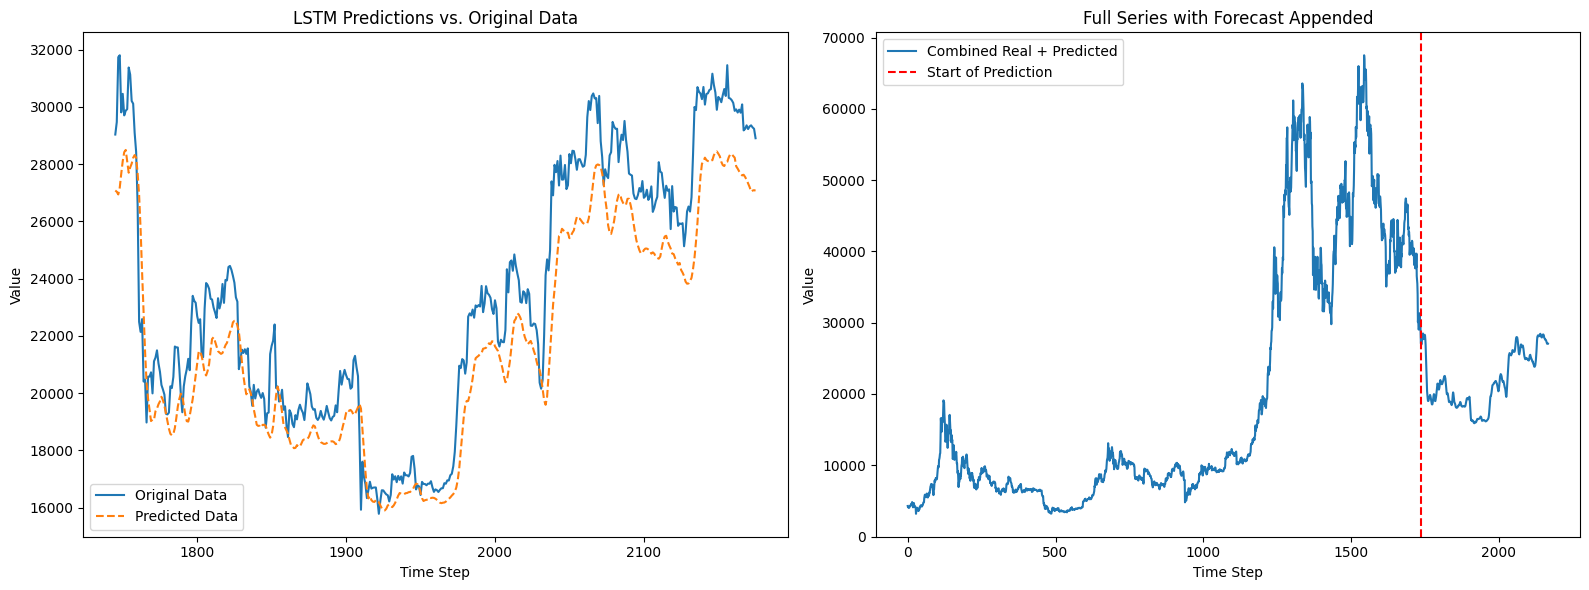

array([ 4285.08      ,  4108.37      ,  4139.98      , ...,
       27072.67406733, 27087.51057024, 27070.71962262])

In [110]:
model.eval()
with torch.no_grad():
    y_pred_test, _, _ = model(X_test)

y_pred_denorm = inverse_transform_single_column(y_pred_test, scaler, num_feat=5)

plot_lstm_forecast(y_pred_denorm, df_close.values, X_close_test, seq_length)